# Codes for semantics spaces explorations 
The codes corresponding to the 4th part in my paper: Exploring Semantic Spaces.

The codes are adapted from week 4 codes and lie in the exercise cells.

# ***What?*** 
Financial news from Done Jones Newswires

## ***Why?***
News are important for analyzing the decision of analysts, and the revisions of analyst forecast is of significance to both investors and researchers. 
Analyst forecast revisions are found to be positively correlated with contemporaneous stock return, and abnormal returns following the stock prices continue to drift in the same direction of the current revision for about six months 

## ***How?***
a. Propose hypothesis about possible determinants of analyst forecast revisions using evidence from relevant literatures.

b. Collect dynamic news data on Wall Street Journal from ProQuest text and data mining (TDM) studios.

c. Get the xml file content, parse the files and convert data of different months into DataFrame using MultiProcessing Pool.

d. Build topic modeling models: use Scikit-learn CountVecterizer to produce term-document matrix and use Scikit-learn NMF model to train the topic modeling, parallelizing using joblib and Dask in the backend.

e. Train dynamic monthly word-embedding models using rolling monthly data in the most recent two years using Word2Vec and Dask DataFrame, extracting the cultural dimensions that are relevant to analyst forecast revisions we mentioned below.

g. Train word-embedding models using the most recent five-year data using Word2Vec and extract the cultural dimensions that have significant explanatory power for analyst forecast revision. For the news happening in the most recent month before the analyst forecast revisions are made, we use the centroid-based text summarization method to extract the centroid vectors of the texts, and project them onto the cultural dimensions we have, to see the direction of impacts the most recent news have on the analyst forecast revisions through the channel of the constructed cultural dimensions.

h. On the other hand, we can also fit the word embedding models to the monthly news before the analyst making the revision, and the word vectors can feed into a machine learning models to further explain or predict the magnitude and dimensions of the forecast revisions.

## ***Which (words)?***
Outside analysts make monthly forecast about target companies' earnings per share (EPS) at certain future times, say 2-year-ahead EPS. As their estimates would have effect on investors' decision making, and more importantly, any deviation from the realized EPS and estimated ones would reflect on the corresponding stock prices. Therefore, we are interested in understanding the decision-making process of the analysts' revision of the monthly EPS forecast.

The revision is approximately made monthly, and as an ocean of news come in during the monthly interval, the value-relevant information embedded in this unstructured datasets are of vital importance. The research question is, what are the determinants for analysts to make forecast revisions for two-year-ahead EPS estimates? In other words, we want to understand what factors contribute to analysts’ decision making when revising the forecast before the actual earnings announcement. While the determinants would have different degrees of correlations with the forecast revision, it’s more ideal that we could develop a prediction model based on the impacting factors.

Therefore, an exploratory analysis of the news data would be a tremendous start. To investigate possible determinants of analyst forecast revisions, the first step is to examine the dimensions that have connection with analyst forecast revisions supported by previous literatures. A topic modeling approach could also help us to have an overview of the trends of dynamic news. Next, we can construct these cultural dimensions using huge corpora of news text from the past and the word embedding models.

In [ ]:
import numpy as np
import pandas

import collections
import random

import spacy

try:
    nlp = spacy.load("en")
except OSError:
    nlp = spacy.load("en_core_web_sm")


import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

def spacy_pos(word_list, model=nlp):
    tags = []
    # spacy expects a string to start doing the pos-tagging so we convert a list to a string
    if type(word_list) == list:
        word_list = ' '.join(word_list)
    doc = model(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

def tag_sents_pos(sentences, model=nlp):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    
    doc = model(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

def tag_sents_ner(sentences, model=nlp):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = model(final_string)
    
    ner_sents = []
    for sent in doc.sents:
        ner_sent = []
        for ent in sent.ents:
            ner_sent.append((ent.text, ent.label_))
        ner_sents.append(pos_sent)
    
    return ner_sents

def word_tokenize(word_list, model=nlp, MAX_LEN=1500000):
    
    tokenized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 
    # since we're only tokenizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list, disable=["parser", "tagger", "ner", "lemmatizer"])
    
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

def sent_tokenize(word_list, model=nlp):
    doc = model(word_list)
    sentences = [sent.text.strip() for sent in doc.sents]
    return sentences

def normalizeTokens(word_list, extra_stop=[], model=nlp, lemma=True, MAX_LEN=1500000):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    # since we're only normalizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list.lower(), disable=["parser", "tagger", "ner"])

    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    # we check if we want lemmas or not earlier to avoid checking every time we loop
    if lemma:
        for w in doc:
            # if it's not a stop word or punctuation mark, add it to our article
            if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
                normalized.append(str(w.lemma_))
    else:
        for w in doc:
            # if it's not a stop word or punctuation mark, add it to our article
            if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
                normalized.append(str(w.text.strip()))

    return normalized

def split_data(data, prob):
    """split data into fractions [prob, 1 - prob]"""
    results = [], []
    for row in data:
        results[0 if random.random() < prob else 1].append(row)
    return results

def count_words(traingDF, textColumn, trainingColumn):
    counts = collections.defaultdict(lambda: [0, 0])
    for index, row in traingDF.iterrows():
        for word in set(row[textColumn]):
            if row[trainingColumn]:
                counts[word][0] += 1
            else:
                counts[word][1] += 1
    return counts

def trainTestSplit(df, holdBackFraction = .2):
    df = df.reindex(np.random.permutation(df.index))
    holdBackIndex = int(holdBackFraction * len(df))
    train_data = df[holdBackIndex:].copy()
    test_data = df[:holdBackIndex].copy()

    return train_data, test_data

In [ ]:
!pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

In [ ]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
#import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, but first we need to define a function to convert directories of text files into DataFrames:

In [ ]:
def loadDir(targetDir, category):
    allFileNames = os.listdir(targetDir)
    #We need to make them into usable paths and filter out hidden files
    filePaths = [os.path.join(targetDir, fname) for fname in allFileNames if fname[0] != '.']

    #The dict that will become the DataFrame
    senDict = {
        'category' : [category] * len(filePaths),
        'filePath' : [],
        'text' : [],
    }

    for fPath in filePaths:
        with open(fPath) as f:
            senDict['text'].append(f.read())
            senDict['filePath'].append(fPath)

    return pandas.DataFrame(senDict)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now we can use the function in all the directories in `data/grimmerPressReleases`

In [ ]:
dataDir = '/content/drive/MyDrive/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorName in [d for d in os.listdir(dataDir) if d[0] != '.']:
    senPath = os.path.join(dataDir, senatorName)
    senReleasesDF = senReleasesDF.append(loadDir(senPath, senatorName), ignore_index = True)

senReleasesDF[:100:10]

,category,filePath,text
0,Klobuchar,/content/drive/MyDrive/grimmerPressReleases/Kl...,...
10,Klobuchar,/content/drive/MyDrive/grimmerPressReleases/Kl...,...
20,Klobuchar,/content/drive/MyDrive/grimmerPressReleases/Kl...,...
30,Klobuchar,/content/drive/MyDrive/grimmerPressReleases/Kl...,...
40,Klobuchar,/content/drive/MyDrive/grimmerPressReleases/Kl...,...
50,Klobuchar,/content/drive/MyDrive/grimmerPressReleases/Kl...,...
60,Klobuchar,/content/drive/MyDrive/grimmerPressReleases/Kl...,...
70,Klobuchar,/content/drive/MyDrive/grimmerPressReleases/Kl...,...
80,Klobuchar,/content/drive/MyDrive/grimmerPressReleases/Kl...,...
90,Klobuchar,/content/drive/MyDrive/grimmerPressReleases/Kl...,...


Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone.

When we normalize here, we don't use the lematized form of the word because we might lose information. Note the parameter in the normalize tokens function.

In [ ]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
#senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, lemma=False) for s in x])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

senReleasesDF[:100:10]

,category,filePath,text,tokenized_sents,normalized_sents
0,Klobuchar,/content/drive/MyDrive/grimmerPressReleases/Kl...,...,"[[Senate, Passes, Klobuchar, Coleman, Amendmen...","[[senate, pass, klobuchar, coleman, amendment]..."
10,Klobuchar,/content/drive/MyDrive/grimmerPressReleases/Kl...,...,"[[Klobuchar, Statement, on, Guatemala, Decisio...","[[klobuchar, statement, guatemala, decision, t..."
20,Klobuchar,/content/drive/MyDrive/grimmerPressReleases/Kl...,...,"[[Klobuchar, Demands, Action, from, Cell, Phon...","[[klobuchar, demand, action, cell, phone, comp..."
30,Klobuchar,/content/drive/MyDrive/grimmerPressReleases/Kl...,...,"[[Klobuchar, Joins, UMD, Women, s, Hockey, Tea...","[[klobuchar, join, umd, woman, s, hockey, team..."
40,Klobuchar,/content/drive/MyDrive/grimmerPressReleases/Kl...,...,"[[Klobuchar, Coleman, Urge, Key, Departments, ...","[[klobuchar, coleman, urge, key, department, e..."
50,Klobuchar,/content/drive/MyDrive/grimmerPressReleases/Kl...,...,"[[Sen, Klobuchar, Part, of, Bipartisan, Group,...","[[sen, klobuchar, bipartisan, group, announce,..."
60,Klobuchar,/content/drive/MyDrive/grimmerPressReleases/Kl...,...,"[[Senator, Klobuchar, Secures, Funding, for, M...","[[senator, klobuchar, secure, fund, minnesota,..."
70,Klobuchar,/content/drive/MyDrive/grimmerPressReleases/Kl...,...,"[[Senator, Klobuchar, Backs, Bipartisan, Agree...","[[senator, klobuchar, back, bipartisan, agreem..."
80,Klobuchar,/content/drive/MyDrive/grimmerPressReleases/Kl...,...,"[[Klobuchar, Carbon, Counter, Passes, First, C...","[[klobuchar, carbon, counter, pass, committee]..."
90,Klobuchar,/content/drive/MyDrive/grimmerPressReleases/Kl...,...,"[[Pushes, for, Veterans, Benefits], [Klobuchar...","[[push, veteran, benefit], [klobuchar, deliver..."


# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data our data we give all the sentences to the trainer:

In [ ]:
# The sg=0 argument indicates that we don't want to use "skipgram" but instead "CBOW"
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum(), sg=0)

Inside the word2vec object, each word has a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [ ]:
senReleasesW2V['president'][:10] #Shortening because it's very large

array([ 0.8665477 ,  2.4117808 , -0.03045651, -1.9912313 ,  1.7774549 ,
        0.66478914, -0.5825992 , -0.5675756 ,  2.539349  , -1.8963355 ],
      dtype=float32)

If you want the full matrix, `syn0` stores all the vectors:

In [ ]:
senReleasesW2V.wv.syn0

array([[-1.2670089 , -0.53365064,  1.5828526 , ..., -0.23642957,
         1.6633048 ,  0.59682626],
       [-0.8292953 , -0.16165936,  0.14277764, ..., -0.9617438 ,
         0.9432754 , -0.6315416 ],
       [-0.29873663, -0.56352854,  0.3015438 , ...,  1.0288727 ,
         1.479231  , -0.58087665],
       ...,
       [ 0.02796649, -0.0236484 , -0.04504264, ...,  0.03707089,
         0.00438674,  0.00795681],
       [-0.04135012, -0.00200209, -0.01617328, ...,  0.02334114,
         0.01653911, -0.04091023],
       [ 0.05527533, -0.03720658, -0.04676748, ...,  0.02871729,
        -0.00336629, -0.04396829]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words:

In [ ]:
senReleasesW2V.wv.index2word[10]

'today'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [ ]:
senReleasesW2V.most_similar('president')

[('administration', 0.8212430477142334),
 ('rollback', 0.6255028247833252),
 ('cheney', 0.6248129606246948),
 ('trim', 0.5245062112808228),
 ('linean', 0.5231867432594299),
 ('ronald', 0.5081411600112915),
 ('george', 0.5074986815452576),
 ('republican', 0.4945312738418579),
 ('escalation', 0.48132017254829407),
 ('presidential', 0.47706422209739685)]

In [ ]:
senReleasesW2V.most_similar('war')

[('invasion', 0.698694109916687),
 ('liberation', 0.6954617500305176),
 ('afghanistan', 0.684306800365448),
 ('invade', 0.6483837962150574),
 ('disobedience', 0.6468708515167236),
 ('unresisted', 0.6323930025100708),
 ('escalate', 0.5909491777420044),
 ('chaos', 0.5842089653015137),
 ('downward', 0.5814633369445801),
 ('insurgency', 0.5789818167686462)]

Find which word least matches the others within a word set (cosine similarity):

In [ ]:
senReleasesW2V.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

'washington'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [ ]:
senReleasesW2V.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

[('johnson', 0.8271840214729309),
 ('nixon', 0.8175007104873657),
 ('ford', 0.762802004814148),
 ('richard', 0.7522808313369751),
 ('reagan', 0.7445831298828125),
 ('lyndon', 0.7336298227310181),
 ('miller', 0.7284919023513794),
 ('desk', 0.725494384765625),
 ('roosevelt', 0.7240588665008545),
 ('sweeney', 0.7240263223648071)]

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset, **Clinton** is to **Democrat** as **Bush** is to **Republican**. Whoah!

We can also save the vectors for later use:

In [ ]:
senReleasesW2V.save("senpressreleasesWORD2Vec")

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [ ]:
numWords = 50
targetWords = senReleasesW2V.wv.index2word[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [ ]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-1.2670089 , -0.53365064,  1.5828526 , ..., -0.23642957,
         1.6633048 ,  0.59682626],
       [-0.8292953 , -0.16165936,  0.14277764, ..., -0.9617438 ,
         0.9432754 , -0.6315416 ],
       [-0.29873663, -0.56352854,  0.3015438 , ...,  1.0288727 ,
         1.479231  , -0.58087665],
       ...,
       [-0.05881401, -0.12766284, -0.83192533, ...,  0.48782375,
         0.6250726 , -0.15720195],
       [-1.0362016 , -1.512452  , -2.4705696 , ..., -1.0250686 ,
         0.27500105, -2.4241488 ],
       [-1.0446763 , -0.17125803,  0.21476477, ...,  0.60955125,
        -0.5406746 ,  0.8338661 ]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [ ]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

We now can plot the points

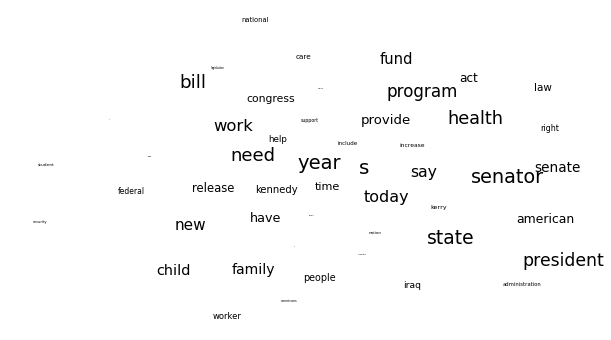

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``said`` next to ``congress`` and ``bill`` near ``act``. ``health`` is beside ``care`` and ``national`` abuts ``security``.

# Chinese examples

In [ ]:
model=gensim.models.Word2Vec.load('/content/drive/MyDrive/1992embeddings_hs_new3.sg')

## analogy

King+man-Queen? A few examples based on a corpus of Chinese news. 

First, location analogy: **province -> capital**

In [ ]:
mm = model.most_similar(positive=[u'长沙',u'陕西'], negative=[u'湖南']) # Changsha + Shaanxi - Hunan
for m in mm:
    print(m[0],m[1])
    print("Xi'an")
    break

西安 0.36609965562820435
Xi'an


In [ ]:
mm = model.most_similar(positive=[u'广州',u'湖北'], negative=[u'广东']) # Guangzhou + Hubei - Guangdong
for m in mm:
    print(m[0],m[1])
    print("Wuhan")
    break

武汉 0.3677000403404236
Wuhan


Second, location analogy: **country -> capital**

In [ ]:
mm = model.most_similar(positive=[u'东京',u'美国'], negative=[u'日本']) # Tokyo + US - Japan
for m in mm:
    print(m[0],m[1])
    print("(Washington DC)")
    break

华盛顿 0.508813738822937
(Washington DC)


## similar words

In [ ]:
word = u'社会主义'  #socialism
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 社会主义 is: 
特色
市场经济
理论
建设
改革开放
马克思主义
党
经济体制
基本路线
现代化



In [ ]:
word = u'玉米'  # corn
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 玉米 is: 
小麦
水稻
作物
棉花
新品种
杂交
大豆
增产
栽培
农作物



## Adding more context - FastText

Since the original word2vec paper, there have followed a slew of word embedding related methods which innovate and build on them in many ways. One popular extension is FastText ([Bojanowski et al. 2017](https://arxiv.org/abs/1607.04606)), which uses sub-words to generate its vectors. Using subwords means that it is powerful in dealing with unknown words and sparse languages that otherwise have a rich morphological structure. These sub-words are incorporated into the previously skipgram and CBOW methods. For example, if the word is “which”, it is represented as the word itself along with a bag of constituent n-grams. If n=3, the representation looks like <wh, whi, hic, ich, ch>, and we learn a representation for each of these constituents, with the word “which” taking on the average value of these constituents. 

FastText can be used either via Gensim or the official package, and primarily has two functions - word representations, and text classification (Joulin et al. 2017). See below for code using the FastText package for playing with word representations, taken from their word representations tutorial (https://fasttext.cc/docs/en/unsupervised-tutorial.html).


### Representations with FastText

We will follow the instructions in the FastText tutorial to prepare our data, (Wikipedia). You can either follow the instructions on the page for setting the data, or download/copy it to drive it from this [Google Drive link](https://drive.google.com/file/d/12T3nNzf0a7tdhm1lVyfz9Ix9XVITFMCP/view?usp=sharing). 

In this example, we will be training a model - it is also possible to download and use the many pre-trained models.

In [ ]:
!pip install fasttext

     |████████████████████████████████| 68 kB 3.6 MB/s 
  Using cached pybind11-2.9.1-py2.py3-none-any.whl (211 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3129037 sha256=efdacc36b47859420df906c659e66aab19164160cd4c8f8494f6a5ebed831ecb
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
import fasttext

In [ ]:
# Replace with the path for where you have placed the 'fil9' file.
file_address = "/content/drive/MyDrive/fil9" 

In [ ]:
model = fasttext.train_unsupervised(file_address)

While FastText is running, the progress and estimated time to completion is shown on your screen. Once the training finishes, the model variable contains information on the trained model, which you can use for querying:



In [ ]:
model.words

It returns all words in the vocabulary, sorted by decreasing frequency. We can get the word vector by:



In [ ]:
model.get_word_vector("the")

In [ ]:
model.save_model("result/fil9.bin")

In [ ]:
# when we want to use the model again
# model = fasttext.load_model("result/fil9.bin")

Let's now print some vectors.

In [ ]:
[model.get_word_vector(x) for x in ["asparagus", "pidgey", "yellow"]]

A nice feature is that you can also query for words that did not appear in your data! Indeed words are represented by the sum of their substrings. As long as the unknown word is made of known substrings, there is a representation of it!

As an example let's try with a misspelled word:



In [ ]:
model.get_word_vector("enviroment")

In [ ]:
# Add FastText here

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project using at least two different specification of `word2vec` and/or `fasttext`, and visualize them each with two separate visualization layout specifications (e.g., TSNE, PCA). Then interrogate critical word vectors within your corpus in terms of the most similar words, analogies, and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the semantic organization of words in your corpora? Which estimation and visualization specification generate the most insight and appear the most robustly supported and why? 

<font color="red">***Stretch***: Explore different vector calculations beyond addition and subtraction, such as multiplication, division or some other function. What does this exploration reveal about the semantic structure of your corpus?

In [ ]:
df_read = pandas.read_pickle("/content/drive/MyDrive/Colab Notebooks/data/final_project/text_data_2017.pkl")
df_read

Company  \
anndats    Date                                                           
2017-01-02 2017-01-01                                              None   
           2017-01-01  \nPUGOY\nRNO.FR\nUG.FR\nVLKAY\nVOW.XE\nVOW3.XE\n   
           2017-01-01  \nPUGOY\nRNO.FR\nUG.FR\nVLKAY\nVOW.XE\nVOW3.XE\n   
           2017-01-01  \nPUGOY\nRNO.FR\nUG.FR\nVLKAY\nVOW.XE\nVOW3.XE\n   
           2017-01-01                                              None   
...                                                                 ...   
2017-12-29 2017-12-28                                              None   
           2017-12-28                                   \nGOOG\nGOOGL\n   
           2017-12-28                                              None   
           2017-12-28                                           \nSNV\n   
           2017-12-28                                          \nCBMG\n   

                                                                   Title  \
anndats    Date                                                            
2017-01-02 2017-01-01  \nInterbank Foreign Exchange Rates At 23:50 ES...   
           2017-01-01     \nFrench New Car Registrations Up 5.1% in 2016   
           2017-01-01  \nRenault New Car Registrations in France Up 0...   
           2017-01-01  \nPeugeot New Car Registrations in France Down...   
           2017-01-01  \nTurkish Authorities Hunt for Gunman in Istan...   
...                                                                  ...   
2017-12-29 2017-12-28  \nUS Chicago Purch Mgmt Adj Dec Index +67.6 vs...   
           2017-12-28       \nVP Campbell Surrenders 201 Of Alphabet Inc   
           2017-12-28             \nZumbrota Hog/Sheep Market For Dec 27   
           2017-12-28  \nVP Copeland Gifts 3,100 Of Synovus Financial...   
           2017-12-28  \nPress Release: Cellular Biomedicine Group An...   

                                                                 Article  \
anndats    Date                                                            
2017-01-02 2017-01-01  \n\n \n                           Latest      ...   
           2017-01-01  \n\n \n\n  (MORE TO FOLLOW) Dow Jones Newswire...   
           2017-01-01  \n\n \n\n  (MORE TO FOLLOW) Dow Jones Newswire...   
           2017-01-01  \n\n \n\n  (MORE TO FOLLOW) Dow Jones Newswire...   
           2017-01-01  \n\nBy Margaret Coker and Emre Peker \n\n     ...   
...                                                                  ...   
2017-12-29 2017-12-28  \n\n \n\n  (MORE TO FOLLOW) Dow Jones Newswire...   
           2017-12-28  \n\n \nSOURCE: Form 4 \n \nISSUER: Alphabet In...   
           2017-12-28  \n\nSource: Central Livestock Association \n \...   
           2017-12-28  \n\n \nSOURCE: Form 4 \n \nISSUER: Synovus Fin...   
           2017-12-28  \n\n  Cellular Biomedicine Group Announces Clo...   

                            System_GMT_Time  \
anndats    Date                               
2017-01-02 2017-01-01  20170102T045016.304Z   
           2017-01-01  20170101T131603.377Z   
           2017-01-01  20170101T131607.523Z   
           2017-01-01  20170101T131611.602Z   
           2017-01-01  20170101T132903.071Z   
...                                     ...   
2017-12-29 2017-12-28  20171228T144546.446Z   
           2017-12-28  20171228T144556.253Z   
           2017-12-28  20171228T144709.774Z   
           2017-12-28  20171228T143246.937Z   
           2017-12-28  20171228T123003.016Z   

                                              Display_ET_Time  \
anndats    Date                                                 
2017-01-02 2017-01-01   January 01, 2017 23:50 ET (04:50 GMT)   
           2017-01-01   January 01, 2017 08:16 ET (13:16 GMT)   
           2017-01-01   January 01, 2017 08:16 ET (13:16 GMT)   
           2017-01-01   January 01, 2017 08:16 ET (13:16 GMT)   
           2017-01-01   January 01, 2017 08:29 ET (13:29 GMT)   
...                                        

In [ ]:
df_read.reset_index(inplace=True)
df_sample = df_read.sample(frac =.01,random_state = 1)
df_sample.to_pickle('/content/drive/MyDrive/Colab Notebooks/data/final_project/sample_data_2017.pkl')

In [ ]:
df_sample

,index,anndats,Date,Company,Title,Article,System_GMT_Time,Display_ET_Time,Accession_Number,title_sent,article_sent
460673,460673,2017-06-09,2017-06-08,None,"\nIreland Sells EUR300M February 2045 Bond, Yi...",\n\n \n\n (MORE TO FOLLOW) Dow Jones Newswire...,20170608T093301.541Z,"June 08, 2017 05:33 ET (09:33 GMT)",20170608002216,0.0000,0.500000
1187718,1187718,2017-12-11,2017-12-10,None,"\nSingapore Shares Edge Up, Helped by US Jobs ...",\n\n 0115 GMT - Singapore shares edge up M...,20171211T011545.108Z,"December 10, 2017 20:15 ET (01:15 GMT)",20171210001427,0.0000,0.163426
486844,486844,2017-06-21,2017-06-20,\nSTT\n,"\nVP Carp Registers 2,656 Of State Street Corp...",\n\n \nSOURCE: Form 144 \n \nISSUER: State Str...,20170620T193413.967Z,"June 20, 2017 15:34 ET (19:34 GMT)",20170620006637,0.0000,-0.400000
704997,704997,2017-08-15,2017-08-14,None,\nCBOT Financial Final Volume/Open Interest - ...,\n\nFor previous business day. Open Interest s...,20170814T140805.248Z,"August 14, 2017 10:08 ET (14:08 GMT)",20170814007327,0.0000,-0.055556
209107,209107,2017-03-14,2017-03-13,\nAEMD\n,\nPress Release: Aethlon Medical Announces The...,\n\n Aethlon Medical Announces The Conclusion...,20170313T111502.122Z,"March 13, 2017 07:15 ET (11:15 GMT)",20170313002768,0.0000,0.057496
...,...,...,...,...,...,...,...,...,...,...,...
317477,317477,2017-04-27,2017-04-26,\nRICK\n,\nRCI Announces Asset Acquisitions of Club and...,\n\n \n\n (MORE TO FOLLOW) Dow Jones Newswire...,20170426T200603.601Z,"April 26, 2017 16:06 ET (20:06 GMT)",20170426012970,0.3500,0.500000
1088156,1088156,2017-11-14,2017-11-13,\n0858.HK\n,\nExtrawell Pharmaceutical Expects Higher Prof...,\n\n \n\n (END) Dow Jones Newswires\n\n Nove...,20171113T095920.351Z,"November 13, 2017 04:59 ET (09:59 GMT)",20171113002377,0.0625,0.000000
785441,785441,2017-09-02,2017-09-01,\nWFC\n,"\nN.Y. Fed: William Dudley Investigated, Clear...",\n\n (MORE TO FOLLOW) Dow Jones Newswires\n\n...,20170901T171947.501Z,"September 01, 2017 13:19 ET (17:19 GMT)",20170901006013,0.0000,0.500000
127215,127215,2017-02-15,2017-02-14,\nAUY\nYRI.T\n,\nPress Release: Yamana Gold Provides An -3-,\n\n Table 1: All drill hole results from the...,20170214T231109.721Z,"February 14, 2017 18:11 ET (23:11 GMT)",20170214015124,0.0000,0.085859


In [ ]:
#Apply our functions, notice each row is a list of lists now
df_sample['tokenized_sents'] = df_sample['Article'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
df_sample['normalized_sents'] = df_sample['tokenized_sents'].apply(lambda x: [normalizeTokens(s, lemma=False, extra_stop=['|','$','+','=','sa','gmt']) for s in x])
#df_read['normalized_sents'] = df_read['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

df_sample

,index,anndats,Date,Company,Title,Article,System_GMT_Time,Display_ET_Time,Accession_Number,title_sent,article_sent,tokenized_sents,normalized_sents
460673,460673,2017-06-09,2017-06-08,None,"\nIreland Sells EUR300M February 2045 Bond, Yi...",\n\n \n\n (MORE TO FOLLOW) Dow Jones Newswire...,20170608T093301.541Z,"June 08, 2017 05:33 ET (09:33 GMT)",20170608002216,0.0000,0.500000,"[[MORE, TO, FOLLOW], [Dow, Jones, Newswires, J...","[[follow], [dow, jones, newswires, june, 05:33..."
1187718,1187718,2017-12-11,2017-12-10,None,"\nSingapore Shares Edge Up, Helped by US Jobs ...",\n\n 0115 GMT - Singapore shares edge up M...,20171211T011545.108Z,"December 10, 2017 20:15 ET (01:15 GMT)",20171210001427,0.0000,0.163426,"[[0115, GMT, Singapore, shares, edge, up, Mond...","[[singapore, shares, edge, monday, helped, str..."
486844,486844,2017-06-21,2017-06-20,\nSTT\n,"\nVP Carp Registers 2,656 Of State Street Corp...",\n\n \nSOURCE: Form 144 \n \nISSUER: State Str...,20170620T193413.967Z,"June 20, 2017 15:34 ET (19:34 GMT)",20170620006637,0.0000,-0.400000,"[[SOURCE, Form, 144, ISSUER], [State, Street, ...","[[source, form, issuer], [state, street, corp]..."
704997,704997,2017-08-15,2017-08-14,None,\nCBOT Financial Final Volume/Open Interest - ...,\n\nFor previous business day. Open Interest s...,20170814T140805.248Z,"August 14, 2017 10:08 ET (14:08 GMT)",20170814007327,0.0000,-0.055556,"[[For, previous, business, day], [Open, Intere...","[[previous, business, day], [open, interest, s..."
209107,209107,2017-03-14,2017-03-13,\nAEMD\n,\nPress Release: Aethlon Medical Announces The...,\n\n Aethlon Medical Announces The Conclusion...,20170313T111502.122Z,"March 13, 2017 07:15 ET (11:15 GMT)",20170313002768,0.0000,0.057496,"[[Aethlon, Medical, Announces], [The, Conclusi...","[[aethlon, medical, announces], [conclusion, h..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
317477,317477,2017-04-27,2017-04-26,\nRICK\n,\nRCI Announces Asset Acquisitions of Club and...,\n\n \n\n (MORE TO FOLLOW) Dow Jones Newswire...,20170426T200603.601Z,"April 26, 2017 16:06 ET (20:06 GMT)",20170426012970,0.3500,0.500000,"[[MORE, TO, FOLLOW], [Dow, Jones, Newswires, 2...","[[follow], [dow, jones, newswires, april, 16:0..."
1088156,1088156,2017-11-14,2017-11-13,\n0858.HK\n,\nExtrawell Pharmaceutical Expects Higher Prof...,\n\n \n\n (END) Dow Jones Newswires\n\n Nove...,20171113T095920.351Z,"November 13, 2017 04:59 ET (09:59 GMT)",20171113002377,0.0625,0.000000,"[[END, Dow, Jones, Newswires, November, 13, 20...","[[end, dow, jones, newswires, november, 04:59,..."
785441,785441,2017-09-02,2017-09-01,\nWFC\n,"\nN.Y. Fed: William Dudley Investigated, Clear...",\n\n (MORE TO FOLLOW) Dow Jones Newswires\n\n...,20170901T171947.501Z,"September 01, 2017 13:19 ET (17:19 GMT)",20170901006013,0.0000,0.500000,"[[MORE, TO, FOLLOW], [Dow, Jones, Newswires, S...","[[follow], [dow, jones, newswires, september, ..."
127215,127215,2017-02-15,2017-02-14,\nAUY\nYRI.T\n,\nPress Release: Yamana Gold Provides An -3-,\n\n Table 1: All drill hole results from the...,20170214T231109.721Z,"February 14, 2017 18:11 ET (23:11 GMT)",20170214015124,0.0000,0.085859,"[[Table, 1], [All, drill, hole, results, from,...","[[table], [drill, hole, results, providencia, ..."


In [ ]:
df_sample = df_sample.reset_index(drop=True).drop(columns="index")
newsW2V = gensim.models.word2vec.Word2Vec(df_sample['normalized_sents'].sum(), sg=0)

In [ ]:
newsW2V.save("newsW2Vec_2017")

In [ ]:
newsW2V['certain'][:10] #Shortening because it's very large

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.23356242,  0.2694559 , -1.189543  ,  0.16835356,  1.7495627 ,
       -0.09975932,  2.3912113 , -0.06709386, -1.452401  ,  0.20403007],
      dtype=float32)

In [ ]:
# get the full matrix
newsW2V.wv.syn0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


array([[ 2.2771952e+00, -2.7173755e-01,  4.2988077e-02, ...,
         2.0799731e-01, -1.2661390e+00, -2.9371461e-01],
       [-1.9284584e-01,  2.5963941e+00,  2.2186396e+00, ...,
        -3.8431304e+00,  7.0910364e-01, -2.2258508e+00],
       [ 1.2194786e+00,  1.2408472e+00, -1.4640156e+00, ...,
        -3.5003612e+00,  3.0471036e-01, -3.8434467e-01],
       ...,
       [ 2.8533123e-02,  6.0455546e-02,  1.4223228e-03, ...,
        -4.6299701e-03, -2.5922524e-02, -2.2715697e-02],
       [ 7.2148949e-02,  1.2659901e-01,  1.9229418e-02, ...,
        -6.2864356e-02, -4.9669951e-02, -1.2537827e-02],
       [ 5.5385221e-02,  3.3412483e-02, -2.3823608e-02, ...,
         4.2510568e-03, -3.4930617e-02,  2.4907047e-02]], dtype=float32)

In [ ]:
# index2word lets you translate from the matrix to words
newsW2V.wv.index2word[10]

'shares'

In [ ]:
newsW2V.most_similar('uncertain')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('uncertainty', 0.8387603759765625),
 ('consequences', 0.815004289150238),
 ('difficult', 0.8107274770736694),
 ('predict', 0.8055638074874878),
 ('unexpected', 0.783180832862854),
 ('lack', 0.7803505659103394),
 ('outcome', 0.778644323348999),
 ('unpredictable', 0.778390645980835),
 ('absence', 0.7723153829574585),
 ('structural', 0.7692853212356567)]

In [ ]:
newsW2V.most_similar('positive')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('positively', 0.7789480686187744),
 ('negative', 0.7676504850387573),
 ('solid', 0.7676279544830322),
 ('weak', 0.7461188435554504),
 ('downward', 0.7406042218208313),
 ('strong', 0.7312257289886475),
 ('stronger', 0.7304487228393555),
 ('despite', 0.7208441495895386),
 ('improvement', 0.7202210426330566),
 ('sustained', 0.7167328000068665)]

In [ ]:
newsW2V.most_similar('price')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('prices', 0.674092173576355),
 ('pricing', 0.6052383184432983),
 ('priced', 0.554495632648468),
 ('premium', 0.539529025554657),
 ('volatility', 0.5332087278366089),
 ('valuation', 0.5190079212188721),
 ('weight', 0.5172910690307617),
 ('maximum', 0.5087270736694336),
 ('volume', 0.5077670812606812),
 ('values', 0.5068649053573608)]

In [ ]:
newsW2V.most_similar('stock')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('retireme', 0.654407262802124),
 ('shares', 0.587490439414978),
 ('share', 0.569541335105896),
 ('ipo', 0.567151665687561),
 ('traded', 0.5273972153663635),
 ('ncib', 0.49655231833457947),
 ('outstanding', 0.4947513937950134),
 ('units', 0.48332855105400085),
 ('closing', 0.4775508642196655),
 ('exercise', 0.4648873507976532)]

In [ ]:
newsW2V.most_similar('forecast')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('projection', 0.7736994028091431),
 ('gdp', 0.7151694297790527),
 ('downward', 0.7075973153114319),
 ('consensus', 0.6992899179458618),
 ('fy', 0.6907299160957336),
 ('1q', 0.6831955909729004),
 ('slight', 0.6701453924179077),
 ('projected', 0.6678175926208496),
 ('median', 0.6622341275215149),
 ('forecasts', 0.6568032503128052)]

In [ ]:
newsW2V.most_similar('revision')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('downward', 0.6949425339698792),
 ('downgrade', 0.692790150642395),
 ('expectation', 0.6820420026779175),
 ('upward', 0.6813136339187622),
 ('indicating', 0.6669085621833801),
 ('negative', 0.6648051142692566),
 ('simulated', 0.6647456288337708),
 ('revised', 0.657730221748352),
 ('assumption', 0.6558386087417603),
 ('stress', 0.6405794024467468)]

In [ ]:
newsW2V.doesnt_match(['price','unemployment','business','coronavirus'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'unemployment'

In [ ]:
newsW2V.most_similar(positive=['optimistic', 'forecast'], negative = ['analyst'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('trend', 0.740863561630249),
 ('somewhat', 0.7294418811798096),
 ('sustained', 0.726111888885498),
 ('slow', 0.723960280418396),
 ('downward', 0.7177110910415649),
 ('slowing', 0.7145942449569702),
 ('seeing', 0.7137243747711182),
 ('modest', 0.7122682332992554),
 ('recession', 0.7080453634262085),
 ('expect', 0.7034046649932861)]

In [ ]:
numWords = 50
targetWords = newsW2V.wv.index2word[:numWords]

In [ ]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(newsW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([[ 2.2771952 , -0.27173755,  0.04298808, ...,  0.2079973 ,
        -1.266139  , -0.2937146 ],
       [-0.19284584,  2.596394  ,  2.2186396 , ..., -3.8431304 ,
         0.70910364, -2.2258508 ],
       [ 1.2194786 ,  1.2408472 , -1.4640156 , ..., -3.5003612 ,
         0.30471036, -0.38434467],
       ...,
       [ 0.10494333, -3.283018  , -0.8171344 , ...,  0.7297319 ,
         1.5087941 ,  1.5195347 ],
       [ 3.5420122 , -0.1827145 , -0.5017582 , ...,  0.6148366 ,
         0.5865339 , -0.23037656],
       [-0.62601405,  2.0052147 , -0.62934476, ...,  0.14652018,
        -0.15402435,  0.13291256]], dtype=float32)

In [ ]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


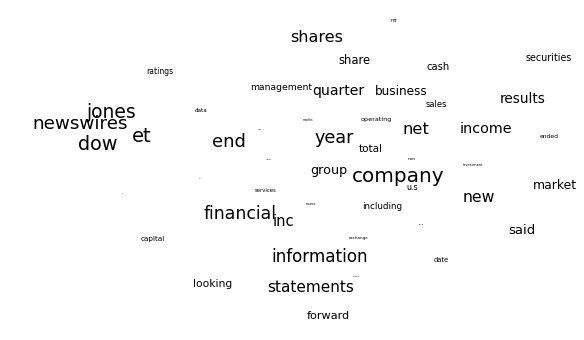

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

optimistic + forecast - analyst = downward, This is to say optimistic to analyst is downward to forecast. This intuition coincide with previous literatures, as analysts tend to be overly optimistic in the beginning of the forecast period and revise downward as it approaches to the forecast period end date.

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [ ]:
apsDF = pandas.read_csv('/content/drive/MyDrive/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

,copyrightYear,doi,abstract
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags.

In [ ]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [ ]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: lucem_illud.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, lemma=False))

In [ ]:
apsDF[:10]

,copyrightYear,doi,abstract,tokenized_words,normalized_words,TaggedAbstracts
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...,"[A, summarizing, account, is, given, of, the, ...","[summarizing, account, given, research, barium...","([summarizing, account, given, research, bariu..."
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...,"[New, tables, of, coulomb, functions, are, pre...","[new, tables, coulomb, functions, presented, i...","([new, tables, coulomb, functions, presented, ..."
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...,"[Ionization, by, electron, impact, in, diatomi...","[ionization, electron, impact, diatomic, gases...","([ionization, electron, impact, diatomic, gase..."
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...,"[It, is, shown, that, the, conductivity, in, t...","[shown, conductivity, ohmic, cuprous, oxide, l...","([shown, conductivity, ohmic, cuprous, oxide, ..."
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...,"[The, factorization, method, is, an, operation...","[factorization, method, operational, procedure...","([factorization, method, operational, procedur..."
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...,"[A, brief, account, is, given, of, Dyson, 's, ...","[brief, account, given, dyson, proof, finitene...","([brief, account, given, dyson, proof, finiten..."
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...,"[A, systematics, is, given, of, all, transitio...","[systematics, given, transitions, odd, nuclei,...","([systematics, given, transitions, odd, nuclei..."
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...,"[A, systematics, of, the, -transitions, of, ev...","[systematics, -transitions, nuclei, given, int...","([systematics, -transitions, nuclei, given, in..."
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...,"[The, available, experiments, on, the, absorpt...","[available, experiments, absorption, spectra, ...","([available, experiments, absorption, spectra,..."
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...,"[The, classical, theory, of, the, dynamics, of...","[classical, theory, dynamics, viscous, fluids,...","([classical, theory, dynamics, viscous, fluids..."


In [ ]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

In [ ]:
apsDF

,copyrightYear,doi,abstract,tokenized_words,normalized_words,TaggedAbstracts
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...,"[A, summarizing, account, is, given, of, the, ...","[summarizing, account, given, research, barium...","([summarizing, account, given, research, bariu..."
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...,"[New, tables, of, coulomb, functions, are, pre...","[new, tables, coulomb, functions, presented, i...","([new, tables, coulomb, functions, presented, ..."
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...,"[Ionization, by, electron, impact, in, diatomi...","[ionization, electron, impact, diatomic, gases...","([ionization, electron, impact, diatomic, gase..."
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...,"[It, is, shown, that, the, conductivity, in, t...","[shown, conductivity, ohmic, cuprous, oxide, l...","([shown, conductivity, ohmic, cuprous, oxide, ..."
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...,"[The, factorization, method, is, an, operation...","[factorization, method, operational, procedure...","([factorization, method, operational, procedur..."
...,...,...,...,...,...,...
9704,1955,10.1103/PhysRev.99.98,Chemical separation of the products resulting ...,"[Chemical, separation, of, the, products, resu...","[chemical, separation, products, resulting, ph...","([chemical, separation, products, resulting, p..."
9705,1955,10.1103/PhysRev.99.986,The generalized Kramers-Kronig dispersion rela...,"[The, generalized, Kramers, Kronig, dispersion...","[generalized, kramers, kronig, dispersion, rel...","([generalized, kramers, kronig, dispersion, re..."
9706,1955,10.1103/PhysRev.99.989,The question is asked whether the lowest order...,"[The, question, is, asked, whether, the, lowes...","[question, asked, lowest, order, tamm, dancoff...","([question, asked, lowest, order, tamm, dancof..."
9707,1955,10.1103/PhysRev.99.996,An explicit formula for the scattering spin ma...,"[An, explicit, formula, for, the, scattering, ...","[explicit, formula, scattering, spin, matrix, ...","([explicit, formula, scattering, spin, matrix,..."


Now we can train a Doc2Vec model:

In [ ]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [ ]:
apsD2V.docvecs[1952]

array([-0.21196003, -0.20226948,  0.1849106 , -0.02641914, -0.18002558,
        0.9952869 , -0.46393135,  0.45951298, -1.2995827 , -0.9792089 ,
       -1.7150936 , -0.90051055, -0.6406101 , -0.4415425 , -0.22921093,
       -0.47229284, -0.9747319 ,  1.6075959 ,  0.45921838, -1.033607  ,
       -0.86985934, -1.1743226 , -0.3564674 ,  0.72077733, -0.41193008,
        0.755428  ,  0.1511335 , -0.11502341, -0.15791045,  0.26452604,
        1.0478908 , -1.3781773 , -0.47578818,  1.0055786 , -0.6112965 ,
        1.4509821 , -1.4734648 , -0.5878605 , -1.6734931 ,  0.17110541,
        0.13245107,  0.6192972 ,  0.3380004 ,  0.7734389 ,  0.45405376,
        0.7645874 , -0.2868263 ,  0.33070597,  1.5805745 , -0.4659213 ,
       -1.3260145 , -1.0921373 ,  0.20031394, -1.7003406 ,  0.52061796,
        1.3128217 , -0.46763986,  0.4270143 ,  1.5713798 , -1.2161646 ,
       -1.149698  , -0.6098318 ,  1.1768997 , -1.3950645 , -1.092555  ,
        0.6551185 , -0.9026476 , -0.9204173 , -0.87758565,  1.36

The words can still be accessed in the same way:

In [ ]:
apsD2V['atom']

array([ 0.37201545,  0.7122063 , -0.6772447 ,  0.5187503 ,  0.05364195,
        0.8188632 , -0.00354335, -0.14917253, -0.90279716,  0.31379363,
       -1.2675624 , -0.53311336,  0.23372385, -0.31783134,  0.39629337,
       -1.1752614 , -0.5953377 ,  0.5229063 , -0.32534394, -0.64476395,
       -0.15733415, -0.6260033 , -0.3264325 , -0.52980816, -1.2010491 ,
       -0.02905217,  0.10836459, -0.6010488 ,  1.1451383 , -0.4376751 ,
        0.4730777 , -0.20259412,  0.24809217, -0.69605756,  0.23748647,
        0.19980392, -0.36335653, -0.8378829 , -0.6374762 , -0.7654375 ,
        0.1095077 , -0.91383624,  0.06455082,  0.6356875 ,  0.5120424 ,
        1.5179749 ,  0.4228719 ,  0.20372894,  0.8502272 , -0.23397563,
       -0.3070361 ,  0.79378337,  0.6941719 , -0.16809432, -0.05671002,
       -0.1052795 , -0.59371465,  0.5089897 ,  0.15298302, -0.8256386 ,
       -0.82280815,  0.26851967,  0.89248776, -0.3658541 , -0.01587184,
       -0.40297496, -0.38431677, -0.92814296,  0.32460812, -0.72

We can still use the ``most_similar`` command to perform simple semantic equations:

In [ ]:
apsD2V.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

[('holes', 0.8057165741920471)]

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [ ]:
apsD2V.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

[('fluid', 0.934807300567627)]

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [ ]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.6237717]], dtype=float32)

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [ ]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

[('10.1103/PhysRev.109.1052', 0.6384949684143066),
 ('10.1103/PhysRev.100.1646', 0.6329227685928345),
 ('10.1103/PhysRev.113.1545', 0.6215622425079346),
 ('10.1103/PhysRev.110.630', 0.6113729476928711),
 ('10.1103/PhysRev.113.479', 0.6076899766921997)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:

In [ ]:
from IPython.display import Image
Image("../data/PhysRev.98.875.jpg", width=1000, height=1000)

Now let's go the other way around and find words most similar to this document:

In [ ]:
apsD2V.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5) 

[('amounting', 0.7705944776535034),
 ('discontinuously', 0.7690105438232422),
 ('attained', 0.7590419054031372),
 ('lorenz', 0.7501641511917114),
 ('raise', 0.7289189100265503)]

We can even look for documents most like a query composed of multiple words:

In [ ]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

[('10.1103/PhysRev.85.1012', 0.761059045791626),
 ('10.1103/PhysRev.102.805', 0.7434149980545044),
 ('10.1103/PhysRev.93.406', 0.7353998422622681),
 ('10.1103/PhysRev.85.120', 0.7214193344116211),
 ('10.1103/PhysRev.89.1165', 0.7189117670059204)]

Now let's plot some words and documents against one another with a heatmap:

In [ ]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

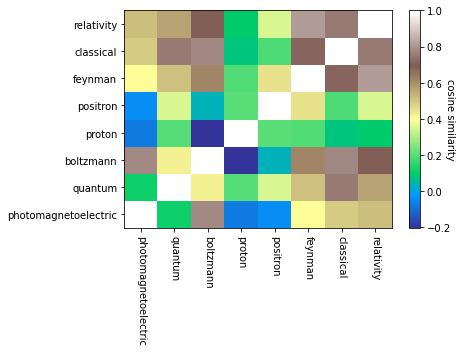

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [ ]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

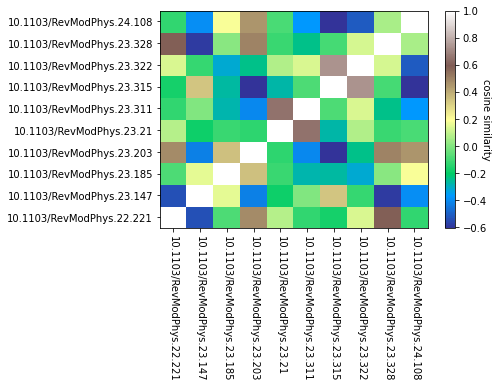

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [ ]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

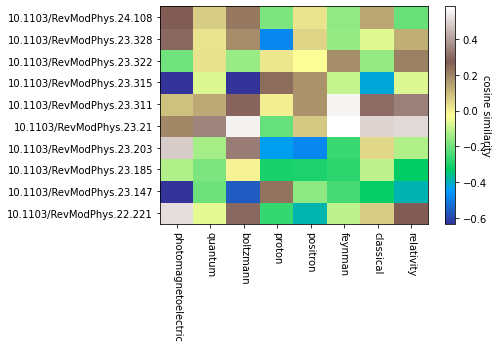

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [ ]:
apsD2V.save('apsW2V')

We can later load it:

In [ ]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project using `doc2vec`, and explore the relationship between different documents and the word vectors you analyzed in the last exercise. Consider the most similar words to critical documents, analogies (doc _x_ + word _y_), and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the documentary organization of your semantic space?

In [ ]:
df_sample = pandas.read_pickle('/content/drive/MyDrive/Colab Notebooks/data/final_project/sample_data_2017.pkl')

In [ ]:
df_sample

,anndats,Date,Company,Title,Article,System_GMT_Time,Display_ET_Time,Accession_Number,title_sent,article_sent,tokenized_sents,normalized_sents
0,2017-06-09,2017-06-08,None,"\nIreland Sells EUR300M February 2045 Bond, Yi...",\n\n \n\n (MORE TO FOLLOW) Dow Jones Newswire...,20170608T093301.541Z,"June 08, 2017 05:33 ET (09:33 GMT)",20170608002216,0.0000,0.500000,"[[MORE, TO, FOLLOW], [Dow, Jones, Newswires, J...","[[follow], [dow, jones, newswires, june, 05:33..."
1,2017-12-11,2017-12-10,None,"\nSingapore Shares Edge Up, Helped by US Jobs ...",\n\n 0115 GMT - Singapore shares edge up M...,20171211T011545.108Z,"December 10, 2017 20:15 ET (01:15 GMT)",20171210001427,0.0000,0.163426,"[[0115, GMT, Singapore, shares, edge, up, Mond...","[[singapore, shares, edge, monday, helped, str..."
2,2017-06-21,2017-06-20,\nSTT\n,"\nVP Carp Registers 2,656 Of State Street Corp...",\n\n \nSOURCE: Form 144 \n \nISSUER: State Str...,20170620T193413.967Z,"June 20, 2017 15:34 ET (19:34 GMT)",20170620006637,0.0000,-0.400000,"[[SOURCE, Form, 144, ISSUER], [State, Street, ...","[[source, form, issuer], [state, street, corp]..."
3,2017-08-15,2017-08-14,None,\nCBOT Financial Final Volume/Open Interest - ...,\n\nFor previous business day. Open Interest s...,20170814T140805.248Z,"August 14, 2017 10:08 ET (14:08 GMT)",20170814007327,0.0000,-0.055556,"[[For, previous, business, day], [Open, Intere...","[[previous, business, day], [open, interest, s..."
4,2017-03-14,2017-03-13,\nAEMD\n,\nPress Release: Aethlon Medical Announces The...,\n\n Aethlon Medical Announces The Conclusion...,20170313T111502.122Z,"March 13, 2017 07:15 ET (11:15 GMT)",20170313002768,0.0000,0.057496,"[[Aethlon, Medical, Announces], [The, Conclusi...","[[aethlon, medical, announces], [conclusion, h..."
...,...,...,...,...,...,...,...,...,...,...,...,...
12447,2017-04-27,2017-04-26,\nRICK\n,\nRCI Announces Asset Acquisitions of Club and...,\n\n \n\n (MORE TO FOLLOW) Dow Jones Newswire...,20170426T200603.601Z,"April 26, 2017 16:06 ET (20:06 GMT)",20170426012970,0.3500,0.500000,"[[MORE, TO, FOLLOW], [Dow, Jones, Newswires, 2...","[[follow], [dow, jones, newswires, april, 16:0..."
12448,2017-11-14,2017-11-13,\n0858.HK\n,\nExtrawell Pharmaceutical Expects Higher Prof...,\n\n \n\n (END) Dow Jones Newswires\n\n Nove...,20171113T095920.351Z,"November 13, 2017 04:59 ET (09:59 GMT)",20171113002377,0.0625,0.000000,"[[END, Dow, Jones, Newswires, November, 13, 20...","[[end, dow, jones, newswires, november, 04:59,..."
12449,2017-09-02,2017-09-01,\nWFC\n,"\nN.Y. Fed: William Dudley Investigated, Clear...",\n\n (MORE TO FOLLOW) Dow Jones Newswires\n\n...,20170901T171947.501Z,"September 01, 2017 13:19 ET (17:19 GMT)",20170901006013,0.0000,0.500000,"[[MORE, TO, FOLLOW], [Dow, Jones, Newswires, S...","[[follow], [dow, jones, newswires, september, ..."
12450,2017-02-15,2017-02-14,\nAUY\nYRI.T\n,\nPress Release: Yamana Gold Provides An -3-,\n\n Table 1: All drill hole results from the...,20170214T231109.721Z,"February 14, 2017 18:11 ET (23:11 GMT)",20170214015124,0.0000,0.085859,"[[Table, 1], [All, drill, hole, results, from,...","[[table], [drill, hole, results, providencia, ..."


In [ ]:
keywords = ['china', 'conference', 'economy', 'trading', 'announcement', 'earnings', 'alpha', 'dividend','analyst','forecast','revision','revise','downward','upward','optimistic','pessimistic']

In [ ]:
df_sample['tokenized_words'] = df_sample['Article'].apply(lambda x: word_tokenize(x))
df_sample['normalized_words'] = df_sample['tokenized_words'].apply(lambda x: normalizeTokens(x, lemma=False, extra_stop=['|','$','-','+','=','sa','gmt']))

In [ ]:
taggedDocs = []
for index, row in df_sample.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['Date'])
    docKeywords.append(row['Accession_Number']) #This lets us extract individual documnets since accession_number's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
df_sample['TaggedArticles'] = taggedDocs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  import sys


In [ ]:
df_sample

,anndats,Date,Company,Title,Article,System_GMT_Time,Display_ET_Time,Accession_Number,title_sent,article_sent,tokenized_sents,normalized_sents,tokenized_words,normalized_words,TaggedArticles
0,2017-06-09,2017-06-08,None,"\nIreland Sells EUR300M February 2045 Bond, Yi...",\n\n \n\n (MORE TO FOLLOW) Dow Jones Newswire...,20170608T093301.541Z,"June 08, 2017 05:33 ET (09:33 GMT)",20170608002216,0.0000,0.500000,"[[MORE, TO, FOLLOW], [Dow, Jones, Newswires, J...","[[follow], [dow, jones, newswires, june, 05:33...","[MORE, TO, FOLLOW, Dow, Jones, Newswires, June...","[follow, dow, jones, newswires, june, 05:33, e...","([follow, dow, jones, newswires, june, 05:33, ..."
1,2017-12-11,2017-12-10,None,"\nSingapore Shares Edge Up, Helped by US Jobs ...",\n\n 0115 GMT - Singapore shares edge up M...,20171211T011545.108Z,"December 10, 2017 20:15 ET (01:15 GMT)",20171210001427,0.0000,0.163426,"[[0115, GMT, Singapore, shares, edge, up, Mond...","[[singapore, shares, edge, monday, helped, str...","[0115, GMT, Singapore, shares, edge, up, Monda...","[singapore, shares, edge, monday, helped, stro...","([singapore, shares, edge, monday, helped, str..."
2,2017-06-21,2017-06-20,\nSTT\n,"\nVP Carp Registers 2,656 Of State Street Corp...",\n\n \nSOURCE: Form 144 \n \nISSUER: State Str...,20170620T193413.967Z,"June 20, 2017 15:34 ET (19:34 GMT)",20170620006637,0.0000,-0.400000,"[[SOURCE, Form, 144, ISSUER], [State, Street, ...","[[source, form, issuer], [state, street, corp]...","[SOURCE, Form, 144, ISSUER, State, Street, Cor...","[source, form, issuer, state, street, corp, sy...","([source, form, issuer, state, street, corp, s..."
3,2017-08-15,2017-08-14,None,\nCBOT Financial Final Volume/Open Interest - ...,\n\nFor previous business day. Open Interest s...,20170814T140805.248Z,"August 14, 2017 10:08 ET (14:08 GMT)",20170814007327,0.0000,-0.055556,"[[For, previous, business, day], [Open, Intere...","[[previous, business, day], [open, interest, s...","[For, previous, business, day, Open, Interest,...","[previous, business, day, open, interest, subj...","([previous, business, day, open, interest, sub..."
4,2017-03-14,2017-03-13,\nAEMD\n,\nPress Release: Aethlon Medical Announces The...,\n\n Aethlon Medical Announces The Conclusion...,20170313T111502.122Z,"March 13, 2017 07:15 ET (11:15 GMT)",20170313002768,0.0000,0.057496,"[[Aethlon, Medical, Announces], [The, Conclusi...","[[aethlon, medical, announces], [conclusion, h...","[Aethlon, Medical, Announces, The, Conclusion,...","[aethlon, medical, announces, conclusion, hemo...","([aethlon, medical, announces, conclusion, hem..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12447,2017-04-27,2017-04-26,\nRICK\n,\nRCI Announces Asset Acquisitions of Club and...,\n\n \n\n (MORE TO FOLLOW) Dow Jones Newswire...,20170426T200603.601Z,"April 26, 2017 16:06 ET (20:06 GMT)",20170426012970,0.3500,0.500000,"[[MORE, TO, FOLLOW], [Dow, Jones, Newswires, 2...","[[follow], [dow, jones, newswires, april, 16:0...","[MORE, TO, FOLLOW, Dow, Jones, Newswires, 212,...","[follow, dow, jones, newswires, april, 16:06, ...","([follow, dow, jones, newswires, april, 16:06,..."
12448,2017-11-14,2017-11-13,\n0858.HK\n,\nExtrawell Pharmaceutical Expects Higher Prof...,\n\n \n\n (END) Dow Jones Newswires\n\n Nove...,20171113T095920.351Z,"November 13, 2017 04:59 ET (09:59 GMT)",20171113002377,0.0625,0.000000,"[[END, Dow, Jones, Newswires, November, 13, 20...","[[end, dow, jones, newswires, november, 04:59,...","[END, Dow, Jones, Newswires, November, 13, 201...","[end, dow, jones, newswires, november, 04:59, ...","([end, dow, jones, newswires, november, 04:59,..."
12449,2017-09-02,2017-09-01,\nWFC\n,"\nN.Y. Fed: William Dudley Investigated, Clear...",\n\n (MORE TO FOLLOW) Dow Jones Newswires\n\n...,20170901T171947.501Z,"September 01, 2017 13:19 ET (17:19 GMT)",20170901006013,0.0000,0.500000,"[[MORE, TO, FOLLOW], [Dow, Jones, Newswires, S...","[[follow], [dow, jones, newswires, september, ...","[MORE, TO, FOLLOW, Dow, Jon

In [ ]:
sampleD2V = gensim.models.doc2vec.Doc2Vec(df_sample['TaggedArticles'], size = 100) #Limiting to 100 dimensions

/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [ ]:
sampleD2V.docvecs[keywords[1]]

array([-4.1187897 ,  1.2864763 ,  2.5807672 , -0.43622088, -1.5300636 ,
       -4.25363   ,  3.2895308 ,  1.4869204 , -0.69877625,  3.6916826 ,
       -0.97565305, -2.3585427 ,  2.3613505 , -0.583319  ,  1.846684  ,
       -0.77687484,  4.1620173 , -1.9473954 ,  2.5698195 ,  0.70182693,
        1.2765265 ,  3.1490502 , -1.1141605 ,  1.2142125 ,  0.25074515,
       -1.9919192 ,  1.2765723 ,  1.5782444 ,  3.2577891 , -2.6569662 ,
       -6.1782074 ,  2.4690442 , -2.0781085 , -2.6954334 ,  1.2162162 ,
       -3.279822  , -0.08950263, -3.4928472 ,  4.7019997 ,  2.0864825 ,
       -1.5722457 , -2.1800377 ,  4.682592  , -0.55376285,  3.8735058 ,
       -0.4749825 ,  0.73744047, -3.0883672 , -0.15402772,  1.692897  ,
        6.742076  , -3.0961652 , -3.9150984 ,  0.6964409 , -0.65061563,
        3.1045358 , -1.605689  ,  1.228908  ,  2.1832173 ,  4.8355727 ,
       -3.363987  , -0.49513558, -3.7647836 , -4.613967  ,  3.500121  ,
       -2.1881106 ,  1.8296589 ,  2.1699858 ,  0.42915896, -2.98

In [ ]:
# what's the difference between vectors of tags and words?
sampleD2V['analyst']

array([-2.6071231 ,  1.6603192 ,  2.1302507 ,  0.35524607, -0.1589658 ,
        2.1553242 ,  1.0116029 , -0.8340862 ,  0.4851775 , -2.0846276 ,
        3.1131666 , -3.4283717 , -0.5718082 ,  2.1710253 ,  0.4266634 ,
        5.9134593 , -1.2812046 ,  2.0800867 , -0.9493114 , -2.056883  ,
        0.8464879 ,  0.06427064,  0.07658564, -0.9248318 ,  3.6039    ,
        0.89007056,  0.8484656 ,  0.54718053, -2.9689574 ,  0.58769715,
       -3.151304  , -2.0075042 , -1.2788111 , -2.6662297 ,  1.5407867 ,
       -1.8752497 ,  0.09034191, -2.2960935 , -0.14590907,  0.97934914,
        2.5121696 ,  1.6693983 , -0.12233367,  0.13927597,  0.26819035,
        0.28860465,  1.1956662 ,  1.315293  ,  1.2588503 , -0.19739206,
       -0.5160876 ,  0.10552096,  0.9003919 ,  3.4839468 , -0.00787195,
       -0.33538285, -0.5362835 , -1.7304254 ,  1.9146662 ,  3.2740366 ,
       -2.4893873 ,  0.00949328,  2.3303523 , -1.2903775 , -0.58518887,
        1.1353872 , -2.252138  ,  2.226859  ,  1.9798641 ,  0.74

In [ ]:
sampleD2V.most_similar(positive = ['downward','optimism'], negative = ['revision'], topn = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('worse', 0.8112118244171143)]

In [ ]:
sampleD2V.most_similar(positive = ['forecast','revise'], negative = ['downward'], topn = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('consulted', 0.7025562524795532)]

In [ ]:
sklearn.metrics.pairwise.cosine_similarity(sampleD2V['forecast'].reshape(1,-1), sampleD2V['optimistic'].reshape(1,-1))

array([[0.5045057]], dtype=float32)

In [ ]:
sampleD2V.docvecs.most_similar([ sampleD2V['negative'] ], topn=5)

[('20170522005205', 0.8408023118972778),
 ('20171204009654', 0.7972781658172607),
 ('20170222004798', 0.7788721323013306),
 ('20170926007623', 0.7697827816009521),
 ('20170426010630', 0.7423035502433777)]

In [ ]:
df_sample.loc[df_sample['Accession_Number'] == '20170926007623'].iloc[0,3]

"\nMoody's Says Windstream's Noteholder Claim Notice Raises Uncertainty, Ratings Unchanged At B1 Negative"

In [ ]:
# find words most similar to this document
sampleD2V.most_similar( [ sampleD2V.docvecs['20170926007623'] ], topn=5) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('downgrade', 0.814071774482727),
 ('trigger', 0.7926933169364929),
 ('scenario', 0.7850903272628784),
 ('reckless', 0.7738451957702637),
 ('absence', 0.7728978395462036)]

In [ ]:
# look for documents most like a query composed of multiple words
sampleD2V.docvecs.most_similar([sampleD2V['analyst']+sampleD2V['forecast']-sampleD2V['downgrade']], topn=5 )

[('20170820000393', 0.6180422902107239),
 ('20171219000005', 0.5860787630081177),
 ('20170720003633', 0.5847019553184509),
 ('20171127000784', 0.5826449394226074),
 ('20171002002821', 0.5747915506362915)]

In [ ]:
df_sample.loc[df_sample['Accession_Number'] == '20170820000393'].iloc[(0,4)]

'\n\n     "Even if the inner Jeffrey is truly composed and collected, the outer Jeffrey is the actor -- he\'s a rational creation who understands how to rattle the cage," said Claude Erb, a former portfolio manager at TCW. "Investors Pull Back From Gundlach\'s Biggest Fund at DoubleLine," published at 8 a.m. ET on Aug. 20 incorrectly stated Mr. Erb had served as a portfolio manager at DoubleLine Capital. \n\n \n\n  (END) Dow Jones Newswires\n\n  August 23, 2017 15:36 ET (19:36 GMT)\n'

In [ ]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = sampleD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, sampleD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

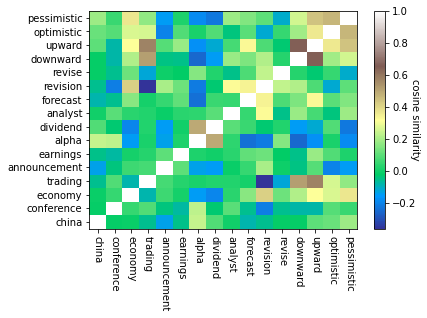

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

In [ ]:
# heatmap of similarities between the first ten documents in the corpus
targetDocs = df_sample['Accession_Number'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = sampleD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, sampleD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

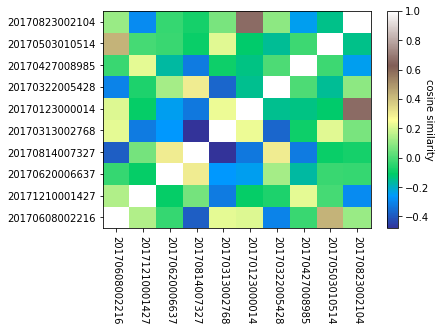

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

In [ ]:
# a heatmap of similarities between the first ten documents and our keywords
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = sampleD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, sampleD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

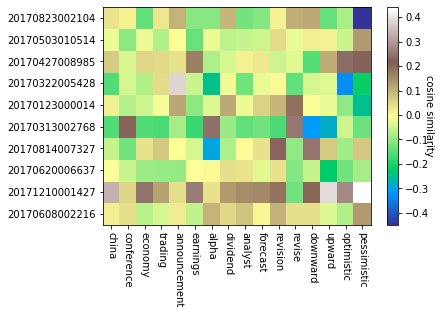

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We can find that there is a significant similarity between the news with accession number 20171210001427 and pessimistic, which indicates this news is primarily is negative.

In [ ]:
df_sample.loc[df_sample['Accession_Number'] == '20171210001427'].iloc[(0,4)]

'\n\n     0115 GMT - Singapore shares edge up Monday helped by strong US jobs data that provide a fresh impetus for risk globally. The benchmark Straits Times Index is up 0.2% at 3432.90 following a 1.1% gain on Friday that finished a choppy week on a strong note. ComfortDelGro is a notable gainer, adding 3.1% after announcing its long-awaited joint venture with Uber late Friday. Singapore Telecommunications and DBS Group are also trading higher. Some real estate and offshore firms, however, are under pressure. Vallianz sheds more than 7% and Sembcorp Marine is down 0.5%.(gaurav.raghuvanshi@wsj.com) \n\n \n\n  (END) Dow Jones Newswires\n\n  December 10, 2017 20:15 ET (01:15 GMT)\n'

In [ ]:
sampleD2V.save("/content/drive/MyDrive/Colab Notebooks/data/final_project/sampleD2V")

In [ ]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [ ]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [ ]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.343139, -0.117117, -0.50773 , ..., -0.995696,  0.921299,
         0.943769],
       [-0.362909, -0.263528,  0.032661, ..., -0.043032, -0.178965,
         0.353556],
       [-0.70167 , -0.344525, -0.320714, ...,  0.009001,  0.11055 ,
         0.751077],
       ...,
       [-2.391626, -1.90143 ,  1.031182, ...,  2.947464,  1.01588 ,
         2.00033 ],
       [-2.432387, -1.161415,  1.060064, ...,  4.402381,  0.500471,
         1.644596],
       [ 0.981931,  0.628094, -0.747547, ...,  1.612927,  1.148063,
         1.063776]], dtype=float32)

In [ ]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

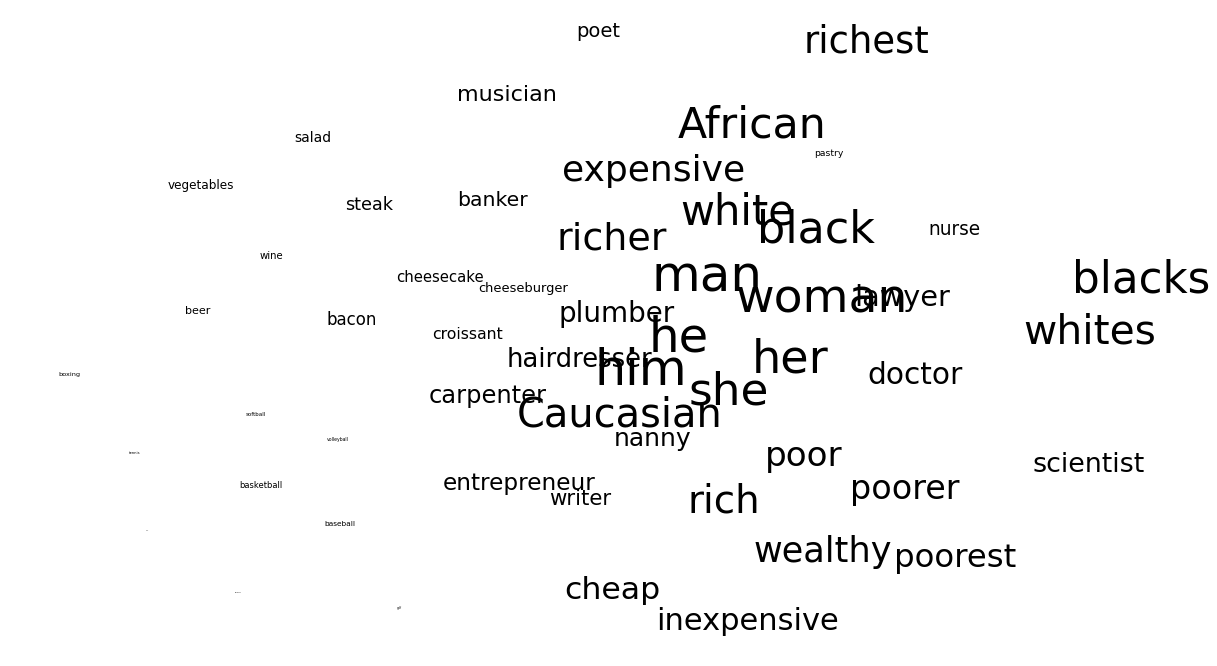

In [ ]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [ ]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [ ]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [ ]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [ ]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [ ]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)
OCCdf

,gender,race,class
doctor,-0.058048,-0.098297,-0.101023
lawyer,0.021787,0.014264,0.052377
plumber,0.038784,-0.082154,-0.003232
scientist,0.053595,-0.107106,0.017319
hairdresser,-0.364141,-0.160411,-0.027526
nanny,-0.220270,-0.135943,-0.008819
carpenter,-0.063229,-0.102722,0.017506
entrepreneur,0.033817,-0.116234,0.177146
musician,-0.079396,-0.080416,0.012577
writer,-0.101106,-0.119433,0.125964


Define some useful functions for plotting.

In [ ]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

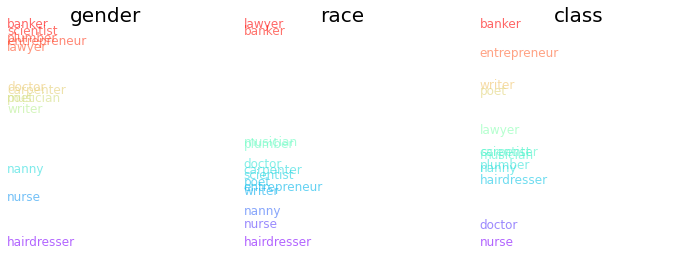

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

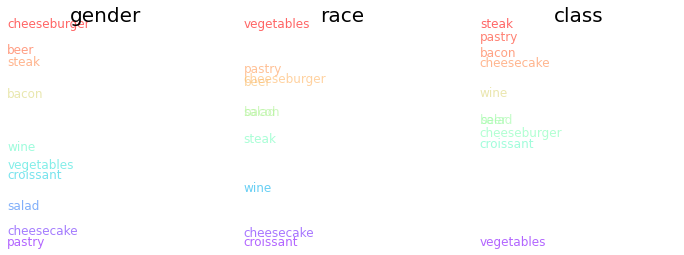

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

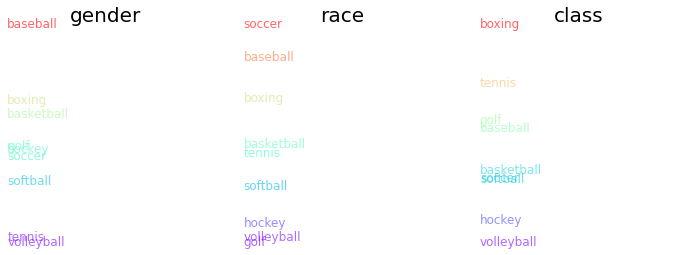

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project, then generate meaningful semantic dimensions based on your theoretical understanding of the semantic space (i.e., by subtracting semantically opposite word vectors) and project another set of word vectors onto those dimensions. Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why? 

<font color="red">***Stretch***: Average together multiple antonym pairs to create robust semantic dimensions. How do word projections on these robust dimensions differ from single-pair dimensions?

In [ ]:
newsWORD2Vec = gensim.models.word2vec.Word2Vec.load('/content/drive/MyDrive/Colab Notebooks/data/final_project/newsW2Vec_2017')


In [ ]:
newsTargetWords = ['good','bad','positive', 'negative', 'increase', 'decrease', 'certain','uncertain','volatile', 'smooth', 'optimistic','revision','revise','upward','downward']
#words we will be mapping
newsTargetWords += ["news","china","trump","trade","economy", "company","earnings","report","conference","dividend", "analyst","forecast",'stock','pessimistic','downgrade','upgrade']


wordsSubMatrix = []
for word in newsTargetWords:
    wordsSubMatrix.append(newsWORD2Vec[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 20).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNews = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


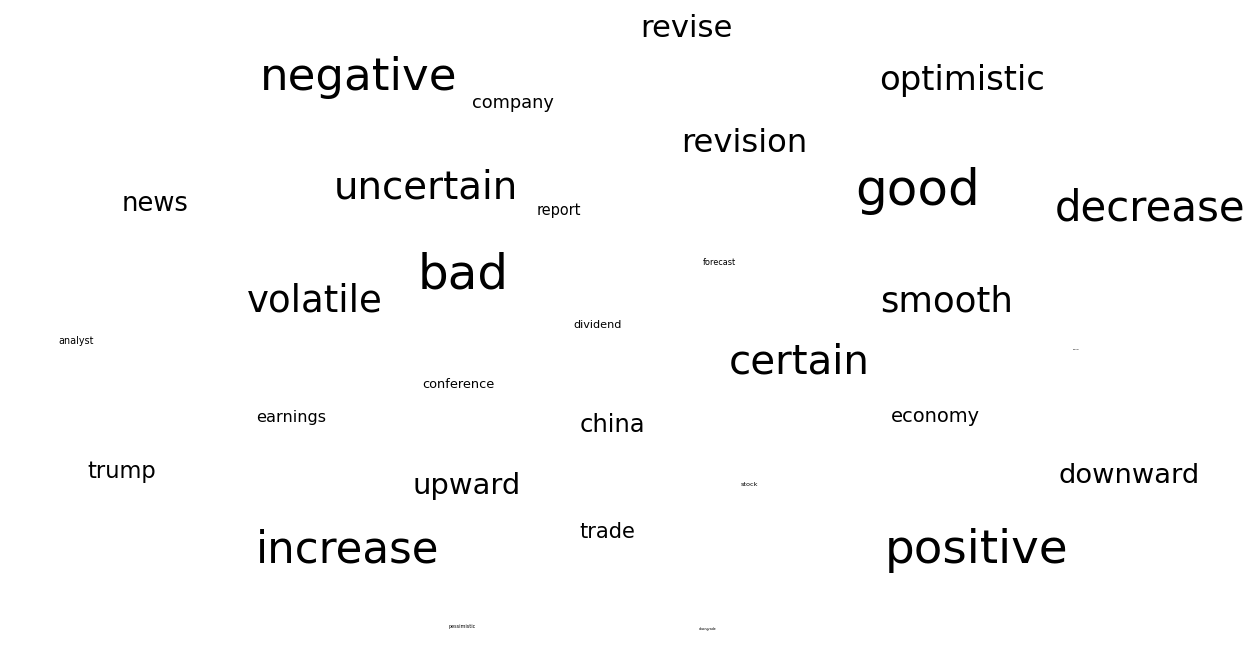

In [ ]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNews[:, 0], tsneWordsNews[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(newsTargetWords):
    ax.annotate(word, (tsneWordsNews[:, 0][i],tsneWordsNews[:, 1][i]), size =  50 * (len(newsTargetWords) - i) / len(newsTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [ ]:
Positivity = dimension(newsWORD2Vec, ['positive','good','better','best','hopeful','dynamic','creative','helpful'], ['bad', 'negative', 'worse', 'worst', 'unfortunate','poor','poorest', 'downgrade', 'depreciation'])
Certainty = dimension(newsWORD2Vec, ['certain','trust','trust','believe', 'belief', 'sure','convince','definite','predictable'],['uncertain', 'volatile','unpredictable','concern','worry','trouble','skepticism'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
Earnings = ["earnings","gain","profit","profitable","income", "revenue","yield","return","finance","fund", "money","interest","revenue"]

People = ["entrepreneur", "banker", "executive", "analyst", "manager", "director", "officer", "economist", "advisor", "agent"]

Actions  = ["merge", "acquisition", "financing", "upgrade", "downgrade", "offering", "bankruptcy", "investing", "borrowing", "lending","revision","forecast","revise"]

In [ ]:
def makeDF(model, word_list):
    p = []
    c = []
    for word in word_list:
        p.append(sklearn.metrics.pairwise.cosine_similarity(newsWORD2Vec[word].reshape(1,-1), Positivity.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(newsWORD2Vec[word].reshape(1,-1), Certainty.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'Positivity': p, 'Certainty': c}, index = word_list)
    return df

In [ ]:
Earningsdf = makeDF(newsWORD2Vec, Earnings) 
Peopledf = makeDF(newsWORD2Vec, People)
Actionsdf = makeDF(newsWORD2Vec, Actions)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/usr/local/lib/python3.7/dist-packages/ip

In [ ]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

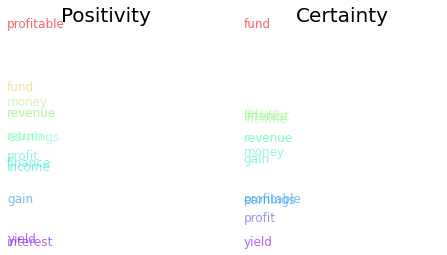

In [ ]:
# Plot the earnings words in each of the two dimensions.
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Earningsdf, 'Positivity')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Earningsdf, 'Certainty')
plt.show()

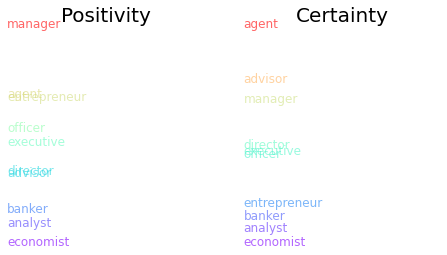

In [ ]:
# Plot the people words in each of the two dimensions.
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Peopledf, 'Positivity')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Peopledf, 'Certainty')
plt.show()

Manager turns out to be the most positive word, while analyst and economist is the least positive word and least certain word in financial news.

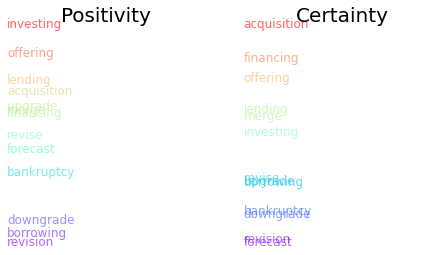

In [ ]:
# Plot the action words in each of the two dimensions.
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Actionsdf, 'Positivity')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Actionsdf, 'Certainty')
plt.show()

# The Score Function

The score function is a simple calculation developed by [Matt Taddy](https://arxiv.org/pdf/1504.07295.pdf) to calculate the likelihood that a given text would have been generated by a word-embedding model by summing the inner product between each pair of the text's word vectors. This relies on a few data files that are not in the git repo due to their size please download and unzip [this](https://github.com/Computational-Content-Analysis-2018/Upcoming/raw/master/data/supplement.zip) (472MB) file in the data directory.

Here, we explore this using a model trained with millions of resumes from the CareerBuilder website (we can't share the private resumes...but we can share a model built with them :-):

In [ ]:
resume_model  = gensim.models.word2vec.Word2Vec.load('../data/resumeAll.model')

We can examine the vacabularies of this model by building a word-index map:

In [ ]:
vocab = resume_model.wv.index2word

Let's just load the sample and take a look at it. The sentences in each job description are already tokenized and normalized.

In [ ]:
sampleDF = pandas.read_csv('../data/SampleJobAds.csv', index_col = False)
#We need to convert the last couple columns from strings to lists
sampleDF['tokenized_sents'] = sampleDF['tokenized_sents'].apply(lambda x: eval(x))
sampleDF['normalized_sents'] = sampleDF['normalized_sents'].apply(lambda x: eval(x))
sampleDF

,Unnamed: 0,hiringOrganization_organizationName,jobDescription,jobLocation_address_region,jobLocation_geo_latitude,jobLocation_geo_longitude,qualifications,responsibilities,tokenized_sents,normalized_sents
0,158844,"Golfsmith International, Inc.","""Sales Associate Tracking Code 220425-971 Job ...",California,33.91918,-118.41647,NaN,"""Ensure each Customer receives exceptional ser...","[[``, Sales, Associate, Tracking, Code, 220425...","[[sales, associate, tracking, code, job, descr..."
1,257645,Intel,For PHY system engineering team within the Wir...,NaN,NaN,NaN,NaN,NaN,"[[For, PHY, system, engineering, team, within,...","[[for, phy, system, engineering, team, within,..."
2,107875,Florida Hospital,*RN Medical Oncology PCU Orlando - Nights* Flo...,Florida,28.53834,-81.37924,NaN,NaN,"[[*RN, Medical, Oncology, PCU, Orlando, -, Nig...","[[medical, oncology, pcu, orlando, florida, ho..."
3,202394,Hitachi Data Systems,Title: Specialist Sales Account Representative...,NaN,NaN,NaN,NaN,NaN,"[[Title, :, Specialist, Sales, Account, Repres...","[[title, specialist, sales, account, represent..."
4,109675,Footprint Retail Services,**Footprint Retail Services** **Job Descriptio...,NaN,NaN,NaN,NaN,A Merchandiser must complete all assigned merc...,"[[**Footprint, Retail, Services**, **Job, Desc...","[[retail, job, title, retail, merchandiser, re..."
5,215973,Home Depot,Position Purpose: Provide outstanding service ...,Indiana,41.13060,-85.12886,NaN,Provide outstanding service to ensure efficien...,"[[Position, Purpose, :, Provide, outstanding, ...","[[position, purpose, provide, outstanding, ser..."
6,207524,Home Depot,The Asset Protection Specialist is primarily r...,New Jersey,40.21455,-74.61932,Must be eighteen years of age or older. Must p...,NaN,"[[The, Asset, Protection, Specialist, is, prim...","[[the, asset, protection, specialist, is, prim..."
7,64426,East West Bank,# Job Description East West Bank is one of the...,California,34.06862,-118.02757,NaN,We are currently seeking a Customer Service Ce...,"[[#, Job, Description, East, West, Bank, is, o...","[[job, description, east, west, bank, is, one,..."
8,245192,IBM,Job Description IBM is seeking to hire a Senio...,NaN,NaN,NaN,NaN,NaN,"[[Job, Description, IBM, is, seeking, to, hire...","[[job, description, ibm, is, seeking, to, hire..."
9,202429,Hitachi Data Systems,Title: Field Solutions Engineer Location: New ...,NaN,NaN,NaN,NaN,Job Functions;Specific duties in this role wil...,"[[Title, :, Field, Solutions, Engineer, Locati...","[[title, field, solutions, engineer, location,..."


Let's define a function to calculate the likelihood of each job description. The idea is borrowed from [Matt Taddy](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/deepir.ipynb), who shows how a document can be characterized as the inner product of the distance between its words. In other words, this analysis will show which job ads are most likely to find an appropriate pool of workers in the resume bank that generated our word embedding.  

In [ ]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

Let's apply this function to every job description.

In [ ]:
sampleDF['likelihood'] = sampleDF['normalized_sents'].apply(lambda x: adprob(x, resume_model))

Let's take a look at the top 5 job descriptions that have the highest likelihood.

In [ ]:
for ad in sampleDF.sort_values(by = 'likelihood', ascending = False)['jobDescription'][:5]:
    print (ad + '\n\n')

Project Engineering including below jobs: 1. Hardware designing of DCS 2. Software configurations, programming, testing of DCS/PLC 3. Testing and FAT 4. Installation and commissioning. 5. Material ordering, approvals of datasheets. 6. HSE compliance as per HSE directives of HON. BE / B. Tech - Instrumentation / Control / Electronics. **Job:** **Engineering* **Title:** *Systems Engineer* **Location:** *IND-MH-Pune* **Requisition ID:** *00302235*


Like talking on the phone? Enjoy giving great customer service? Use those skills while working flexible,part time hours.


*# Positions:* 2 *Location:* US - UT - Orem *Category:* Engineering


Title: Respiratory Therapy, Intern Location: XX-XX-XX


Title: Position Opening at Illinois Wesleyan University Location: US-IL-Bloomington




Let's take a look at the bottom 5 job descriptions that have the lowest likelihood to be matched by the resumes.

In [ ]:
for ad in sampleDF.sort_values(by = 'likelihood')['jobDescription'][:5]:
    print (ad + '\n\n')

Title: Contract Svc Admin Location: United States\-Michigan\-Caledonia Other Locations: JOB SUMMARY: ESSENTIAL DUTIES AND RESPONSIBILITIES: _ Other duties may be assigned:_ Prepare GPO rebate data for upload into STARR system oEnsure accurate data loads oProcess data into required reports oEnsure that GPOs are paid accurately and timely Prepare Sales Tracing data for upload into STARR system oEnsure accurate data loads oProcess data into required reports Prepare Rebate data for upload into STARR system oEnsure accurate data loads oProcess data into required reports oEnsure that distributors are accurately taking rebates against open invoices Manage work flow throughout the sales contracting process Ensure compliance with contract policies and performance requirements Assist in the preparation of charts and sales reports and analytics for customers and Management oQuarterly Reports oSales Tracing Answers customers and internal sale/customer service staff questions regarding pricing Mana

We can do the same for phrases corresponding to job skills.

In [ ]:
adprob([["python", "programming"]], resume_model)

-14.355247

In [ ]:
adprob([["julia", "programming"]], resume_model)

-33.427353

Basic programming appears to be more likely in this pool of resumes than python programming. 

We can also do some simple statistics. Unfortunately, we don't have a large sample here. Nevertheless, let's first look at the mean likelihood score of each hiring organization. Some organizations will do well to hire on CareerBuilder...while others will not.

In [ ]:
sampleDF.groupby("hiringOrganization_organizationName")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
hiringOrganization_organizationName,
Honeywell,-25.974749
Legrand North America,-40.500500
Franciscan St. Eilzabeth Health,-43.167206
Illinois Wesleyan University,-52.681591
Gold's Gym,-75.230896
Jewel-Osco,-80.965462
Ingersoll Rand,-81.494949
Kaiser Permanente,-85.523113
Hallmark Health,-86.037094


We can also look at the mean likelihood of each state.

In [ ]:
sampleDF.groupby("jobLocation_address_region")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
jobLocation_address_region,
Utah,-40.500500
Montana,-63.730721
Connecticut,-67.623466
Kansas,-85.259682
Tennessee,-93.188822
Illinois,-93.989101
New Hampshire,-94.109772
Georgia,-102.271820
South Carolina,-103.527328


You would increase the sample size if you want to do a more serious study.

## <font color="red">*Exercise 4a*</font>

<font color="red">**Do only 4a or 4b.** Construct cells immediately below this that calculate the scores for a small sample of documents from outside your corpus to identify which are *closest* to your corpus. Then calculate the scores for a few phrases or sentences to identify the ones most likely to have appeared in your corpus. Interrogate patterns associated with these document/phrase scores (e.g., which companies produced job ads most or least likely to find jobseekers in the resume corpus?) What do these patterns suggest about the boundaries of your corpus?

# Linguistic Change or Difference

Below is code that aligns the dimensions of multiple embeddings arrayed over time or some other dimension and allow identification of semantic chanage as the word vectors change their loadings for focal words. This code comes from the approach piloted at Stanford by William Hamilton, Daniel Jurafsky and Jure Lescovec [here](https://arxiv.org/pdf/1605.09096.pdf). 

In [ ]:
import copy

In [ ]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In [ ]:
ascoDF = pandas.read_csv("../data/ASCO_abstracts.csv", index_col=0)

In order to explore this, let's get some data that follows a time trend. We'll look at conference proceedings from the American Society for Clinical Oncologists.

Prepare for wor2vec:

In [ ]:
ascoDF['tokenized_sents'] = ascoDF['Body'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
ascoDF['normalized_sents'] = ascoDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

In [ ]:
ascoDF

,Year,AbstractCategory,Title,FirstAuthor,Body,AbstractPublicationID,tokenized_sents,normalized_sents
0,1995,Lung Cancer,Treatment of non-small cell lung cancer with c...,GP Stathopoulos,Cisplatin compound is established as the main ...,1181,"[[Cisplatin, compound, is, established, as, th...","[[cisplatin, compound, establish, main, drug, ..."
1,1995,Breast Cancer,Treatment of primary breast cancer without mas...,A Bluming,"Between March 24, 1977, and March 24, 1983, 15...",270,"[[Between, March, 24, 1977, and, March, 24, 19...","[[march, march, woman, primary, breast, cancer..."
2,1995,Gynecologic Cancer,Treatment of relapsed ovarian carcinoma with e...,M Metzner,ECF has established activity and a high respon...,784,"[[ECF, has, established, activity, and, a, hig...","[[ecf, establish, activity, high, response, ra..."
3,1995,Lung Cancer,Treatment of small cell lung cancer (SCLC) wit...,JD Hainsworth,"In 7/93, we began investigation of a three-dru...",1197,"[[In, 7/93, we, began, investigation, of, a, t...","[[begin, investigation, drug, combination, pac..."
4,1995,Other Gastrointestinal Cancer,Vaccine-based (active specific) chemoimmunothe...,SH Itzkowitz,Active specific immunotherapy (ASI) is the adm...,549,"[[Active, specific, immunotherapy, ASI, is, th...","[[active, specific, immunotherapy, asi, admini..."
5,1995,Breast Cancer,Validation of a model that identifies high ris...,GM Clark,Breast cancer patients with 10 or more positiv...,69,"[[Breast, cancer, patients, with, 10, or, more...","[[breast, cancer, patient, positive, lymph, no..."
6,1995,Genitourinary Cancer,Validation of the PROSQOLI: a pragmatic outcom...,M Stockler,Rationale: Traditional outcome measures are un...,649,"[[Rationale], [Traditional, outcome, measures,...","[[rationale], [traditional, outcome, measure, ..."
7,1995,Preclinical Experimental Therapeutics - Other,'In vitro' comparative assay on fluorouracil (...,A Abad,The clinical experience with biochemical modul...,1609,"[[The, clinical, experience, with, biochemical...","[[clinical, experience, biochemical, modulatio..."
8,1995,Tumor Biology,'Medical cultural diversity' among medical onc...,R Hochman,Most MO rely on prospective randomized trials....,1633,"[[Most, MO, rely, on, prospective, randomized,...","[[mo, rely, prospective, randomize, trial], [o..."
9,1995,Developmental TherapeuticsÑClinical Pharmacolo...,13-cis-retinoic acid plus low dose recombinant...,GM Turola,Both interferons and retinoids are known to po...,709,"[[Both, interferons, and, retinoids, are, know...","[[interferon, retinoid, know, possess, antipro..."


We will be creating many embeddings so we have created this function to do most of the work. It creates two collections of embeddings, one the original and one the aligned.

In [ ]:
def compareModels(df, category, text_column_name='normalized_sents', sort = True, embeddings_raw={}):
    """If you are using time as your category sorting is important"""
    if len(embeddings_raw) == 0:
        embeddings_raw = rawModels(df, category, text_column_name, sort)
    cats = sorted(set(df[category]))
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [ ]:
def rawModels(df, category, text_column_name='normalized_sents', sort = True):
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF[text_column_name].sum())
    return embeddings_raw

Now we generate the models:

In [ ]:
rawEmbeddings, comparedEmbeddings = compareModels(ascoDF, 'Year')

In [ ]:
rawEmbeddings.keys()

dict_keys([1995, 1996, 1997, 1998, 1999, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011])

We need to compare them across all permutions so we will define another function to help, we will be using 1 - cosine similarity as that gives a more intitive range of 0-2 with low values meaning little change and high meaning lots of change.

In [ ]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pandas.DataFrame(dists, index = cats)

Lets look at a couple words:

breast


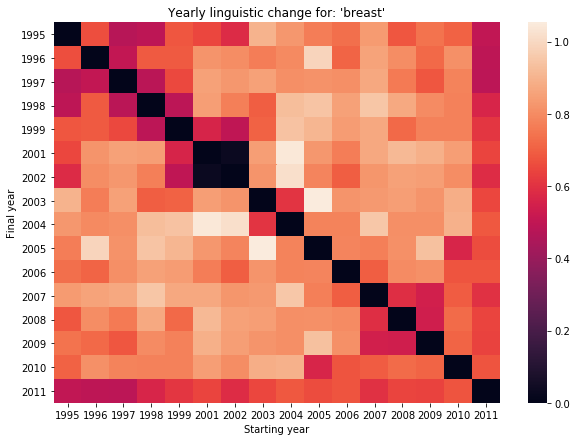

In [ ]:
targetWord = 'breast'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [ ]:
targetWord = 'combination'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [ ]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    

In [ ]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 1571 words to compare


The most divergent words are:

In [ ]:
wordDivergences[:20]

[('t', 13.179612953215837),
 ('toxicity', 13.154180981218815),
 ('ml', 13.01737873442471),
 ('+', 12.853400095365942),
 ('activity', 12.749210256617516),
 ('infusion', 12.687976829707623),
 ('paclitaxel', 12.683675490319729),
 ('n', 12.662226218730211),
 ('great', 12.659880327060819),
 ('level', 12.559175675734878),
 ('x', 12.508285094052553),
 ('phase', 12.495868034660816),
 ('cisplatin', 12.456645250320435),
 ('combination', 12.417438723146915),
 ('c', 12.407136777415872),
 ('p', 12.399663124466315),
 ('efficacy', 12.373506214469671),
 ('csf', 12.333098318078555),
 ('show', 12.330282736569643),
 ('iv', 12.321207114960998)]

And the least:

In [ ]:
wordDivergences[-20:]

[('answer', 1.7252497673034668),
 ('device', 1.721915602684021),
 ('facilitate', 1.720019280910492),
 ('additionally', 1.685628592967987),
 ('particular', 1.6720524430274963),
 ('ensure', 1.6524746417999268),
 ('context', 1.650183618068695),
 ('definition', 1.6107643842697144),
 ('difficulty', 1.6012009978294373),
 ('discuss', 1.5829300284385681),
 ('call', 1.5171823501586914),
 ('traditional', 1.4596245288848877),
 ('nature', 1.44323068857193),
 ('constitute', 1.4302696585655212),
 ('simple', 1.410505771636963),
 ('practical', 1.3745331764221191),
 ('special', 1.294035017490387),
 ('uncertain', 1.2042807936668396),
 ('situation', 1.1920225620269775),
 ('view', 1.1317378878593445)]

t


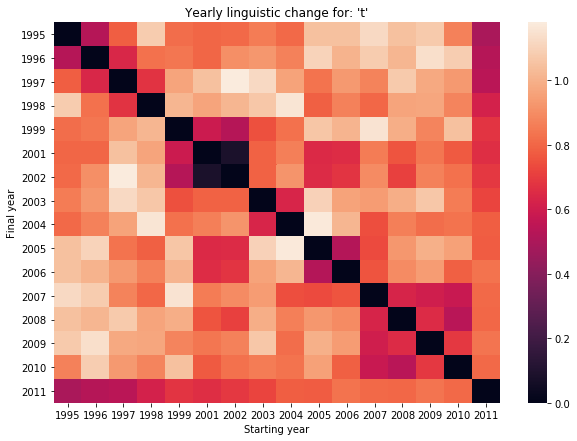

In [ ]:
targetWord = wordDivergences[0][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [ ]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

## COHA

COHA is a historial dataset so it ends up being a good choice to try the same analysis we just did across three different time periods.

We will be using the same data loading procedure as the last notebook, so go through the process to make sure you know what's going on.

In [ ]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/COHA"

In [ ]:
coha_texts = lucem_illud.loadDavies(corpora_address, return_raw=True)

text_1940s_bsw.zip
text_1920s_gte.zip
text_1900s_mse.zip
text_1810s_kso.zip
text_2000s_scc.zip
text_1910s_jue.zip
text_1890s_jsq.zip
text_1870s_vuy.zip
text_1840s_nsq.zip
text_1860s_psi.zip
text_1950s_ndz.zip
text_1820s_jsi.zip
text_1980s_bkk.zip
text_1930s_bie.zip
text_1960s_xus.zip
text_1990s_bsj.zip
text_1830s_bsu.zip
text_1850s_jpr.zip
text_1970s_jfy.zip
text_1880s_azz.zip


Cool - let us now create our different epochs. This is an important step: I will be using the same 5 epochs I did in the DTM example, but you are recommended to play around with this. I will create a dataframe which logs the year and the genre.

In [ ]:
coha_df = pandas.DataFrame(columns=["Year", "Genre", "Epoch", "normalized sents"])

In [ ]:
for article in coha_texts:
    genre, year, id_ = article.split("_")

    year = int(year)
    
    if year > 1810 and year < 1880:
        epoch = 0
    if year >= 1880 and year < 1913:
        epoch = 1
    if year >= 1913 and year < 1950:
        epoch = 2
    if year >= 1950 and year < 1990:
        epoch = 3
    if year >= 1990:
        epoch = 4
    
    try:
        if len(coha_texts[article][2]) < 1500000:
            coha_df.loc[id_] = [year, genre, epoch, lucem_illud.normalizeTokens(coha_texts[article][2].decode("utf-8"), lemma=False)]
    except TypeError:
        continue
    except IndexError:
        continue

We can now arrange our word embeddings by either year, genre, or epoch, and see how the words in each of those contexts change.

In [ ]:
rawEmbeddings_epoch = rawModels(coha_df, 'Epoch', text_column_name='normalized sents')

In [ ]:
# rawEmbeddings_genre = rawModels(coha_df, 'Genre', text_column_name='normalized sents')

We now have the raw embeddings for epoch and genre. You can test out the previous analysis on words of your choice.

In [ ]:
for epoch, embedding in enumerate(rawEmbeddings_epoch):
    model = rawEmbeddings_epoch[embedding]
    name = "embedding_epoch_" + str(epoch)
    model.save(name)

In [ ]:
# for embedding in rawEmbeddings_genre:
#     model = rawEmbeddings_genre[embedding]
#     name = "embedding_genre_" + embedding
#     model.save(name)

In [ ]:
from gensim.models import Word2Vec

In [ ]:
def file_to_embeddings(address, kind):
    rawEmbeddings = {}
    for file in os.listdir(address):
        if "embedding_"+kind in file:
            e, kind_, kind_type = file.split("_")
            kind_type = eval(kind_type)
            rawEmbeddings[kind_type] = Word2Vec.load(file)
    return rawEmbeddings

In [ ]:
# rawEmbeddings_genre_load = file_to_embeddings(".", "genre")

In [ ]:
rawEmbeddings_epoch_load = file_to_embeddings(".", "epoch")

In [ ]:
rawEmbeddings_epoch_load.keys()

dict_keys([0, 1, 2, 3, 4])

In [ ]:
rawEmbeddings_epoch, compared_epoch = compareModels(coha_df, 'Epoch', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_epoch_load)

In [ ]:
# rawEmbeddings_genre, compared_genre = compareModels(coha_df, 'Genre', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_genre_load)

You now have access to the epoch wise embeddings, and the code to train models genre wise (commented out). You can use the original embeddings, the compared embeddings and such to perform the analysis we did before.

## <font color="red">*Exercise 4b*</font>

<font color="red">**Do only 4a or 4b.** Construct cells immediately below this that align word embeddings over time or across domains/corpora. Interrogate the spaces that result and ask which words changed most and least over the entire period or between contexts/corpora. What does this reveal about the social game underlying your space? 

There is much more we do not have time to cover on word embeddings. If you are interested in other ways to align word embeddings, take a look at the [Dynamic Word Embeddings (DTM) section from the Thinking with Deep Learning course](https://colab.research.google.com/drive/1RAiI3BIL1X9D4gzZ0rZdIJjkNNicIuKE?usp=sharing#scrollTo=COS_n2RFCJNk) or using the more recent [Temporal Word Embeddings with a Compass (TWEC) package](https://github.com/valedica/twec). There is also a useful section on [debiasing word embeddings](https://colab.research.google.com/drive/1RAiI3BIL1X9D4gzZ0rZdIJjkNNicIuKE?usp=sharing#scrollTo=JHQ--EsWoxGM), such as the famous, ["Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings"](https://arxiv.org/abs/1607.06520) paper. Below, we include an optional section on topic modeling with word embeddings, which could be useful for final projects.

In [ ]:
#Apply our functions, notice each row is a list of lists now
df_sample['tokenized_sents'] = df_sample['Article'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
df_sample['normalized_sents'] = df_sample['tokenized_sents'].apply(lambda x: [normalizeTokens(s, lemma=False, extra_stop=['|','$','+','=','sa','gmt']) for s in x])
#df_read['normalized_sents'] = df_read['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

df_sample

In [ ]:
df_sample

,anndats,Date,Company,Title,Article,System_GMT_Time,Display_ET_Time,Accession_Number,title_sent,article_sent,tokenized_sents,normalized_sents,tokenized_words,normalized_words,TaggedArticles
0,2017-06-09,2017-06-08,None,"\nIreland Sells EUR300M February 2045 Bond, Yi...",\n\n \n\n (MORE TO FOLLOW) Dow Jones Newswire...,20170608T093301.541Z,"June 08, 2017 05:33 ET (09:33 GMT)",20170608002216,0.0000,0.500000,"[[MORE, TO, FOLLOW], [Dow, Jones, Newswires, J...","[[follow], [dow, jones, newswires, june, 05:33...","[MORE, TO, FOLLOW, Dow, Jones, Newswires, June...","[follow, dow, jones, newswires, june, 05:33, e...","([follow, dow, jones, newswires, june, 05:33, ..."
1,2017-12-11,2017-12-10,None,"\nSingapore Shares Edge Up, Helped by US Jobs ...",\n\n 0115 GMT - Singapore shares edge up M...,20171211T011545.108Z,"December 10, 2017 20:15 ET (01:15 GMT)",20171210001427,0.0000,0.163426,"[[0115, GMT, Singapore, shares, edge, up, Mond...","[[singapore, shares, edge, monday, helped, str...","[0115, GMT, Singapore, shares, edge, up, Monda...","[singapore, shares, edge, monday, helped, stro...","([singapore, shares, edge, monday, helped, str..."
2,2017-06-21,2017-06-20,\nSTT\n,"\nVP Carp Registers 2,656 Of State Street Corp...",\n\n \nSOURCE: Form 144 \n \nISSUER: State Str...,20170620T193413.967Z,"June 20, 2017 15:34 ET (19:34 GMT)",20170620006637,0.0000,-0.400000,"[[SOURCE, Form, 144, ISSUER], [State, Street, ...","[[source, form, issuer], [state, street, corp]...","[SOURCE, Form, 144, ISSUER, State, Street, Cor...","[source, form, issuer, state, street, corp, sy...","([source, form, issuer, state, street, corp, s..."
3,2017-08-15,2017-08-14,None,\nCBOT Financial Final Volume/Open Interest - ...,\n\nFor previous business day. Open Interest s...,20170814T140805.248Z,"August 14, 2017 10:08 ET (14:08 GMT)",20170814007327,0.0000,-0.055556,"[[For, previous, business, day], [Open, Intere...","[[previous, business, day], [open, interest, s...","[For, previous, business, day, Open, Interest,...","[previous, business, day, open, interest, subj...","([previous, business, day, open, interest, sub..."
4,2017-03-14,2017-03-13,\nAEMD\n,\nPress Release: Aethlon Medical Announces The...,\n\n Aethlon Medical Announces The Conclusion...,20170313T111502.122Z,"March 13, 2017 07:15 ET (11:15 GMT)",20170313002768,0.0000,0.057496,"[[Aethlon, Medical, Announces], [The, Conclusi...","[[aethlon, medical, announces], [conclusion, h...","[Aethlon, Medical, Announces, The, Conclusion,...","[aethlon, medical, announces, conclusion, hemo...","([aethlon, medical, announces, conclusion, hem..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12447,2017-04-27,2017-04-26,\nRICK\n,\nRCI Announces Asset Acquisitions of Club and...,\n\n \n\n (MORE TO FOLLOW) Dow Jones Newswire...,20170426T200603.601Z,"April 26, 2017 16:06 ET (20:06 GMT)",20170426012970,0.3500,0.500000,"[[MORE, TO, FOLLOW], [Dow, Jones, Newswires, 2...","[[follow], [dow, jones, newswires, april, 16:0...","[MORE, TO, FOLLOW, Dow, Jones, Newswires, 212,...","[follow, dow, jones, newswires, april, 16:06, ...","([follow, dow, jones, newswires, april, 16:06,..."
12448,2017-11-14,2017-11-13,\n0858.HK\n,\nExtrawell Pharmaceutical Expects Higher Prof...,\n\n \n\n (END) Dow Jones Newswires\n\n Nove...,20171113T095920.351Z,"November 13, 2017 04:59 ET (09:59 GMT)",20171113002377,0.0625,0.000000,"[[END, Dow, Jones, Newswires, November, 13, 20...","[[end, dow, jones, newswires, november, 04:59,...","[END, Dow, Jones, Newswires, November, 13, 201...","[end, dow, jones, newswires, november, 04:59, ...","([end, dow, jones, newswires, november, 04:59,..."
12449,2017-09-02,2017-09-01,\nWFC\n,"\nN.Y. Fed: William Dudley Investigated, Clear...",\n\n (MORE TO FOLLOW) Dow Jones Newswires\n\n...,20170901T171947.501Z,"September 01, 2017 13:19 ET (17:19 GMT)",20170901006013,0.0000,0.500000,"[[MORE, TO, FOLLOW], [Dow, Jones, Newswires, S...","[[follow], [dow, jones, newswires, september, ...","[MORE, TO, FOLLOW, Dow, Jon

In [ ]:
rawEmbeddings, comparedEmbeddings = compareModels(df_sample, 'Date')

In [ ]:
rawEmbeddings.keys()

dict_keys(['20200401', '20200402', '20200403', '20200404', '20200405', '20200406', '20200407', '20200408', '20200409', '20200410', '20200411', '20200412', '20200413', '20200414', '20200415', '20200416', '20200417', '20200418', '20200419', '20200420', '20200421', '20200422', '20200423', '20200424', '20200425', '20200426', '20200427', '20200428', '20200429', '20200430'])

company


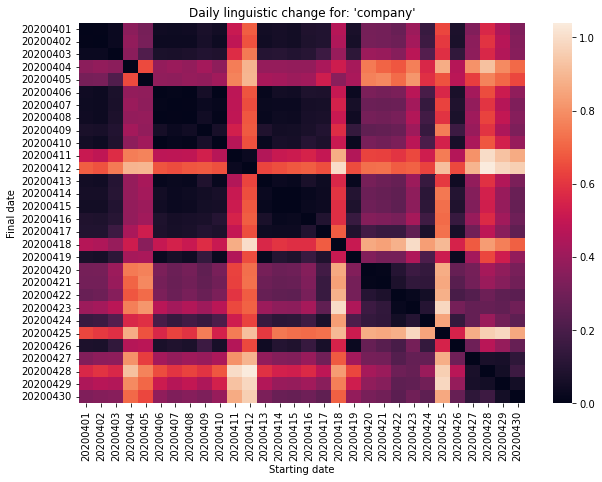

In [ ]:
targetWord = 'company'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting date")
ax.set_ylabel("Final date")
ax.set_ylabel("Final date")
ax.set_title("Daily linguistic change for: '{}'".format(targetWord))
plt.show()

price


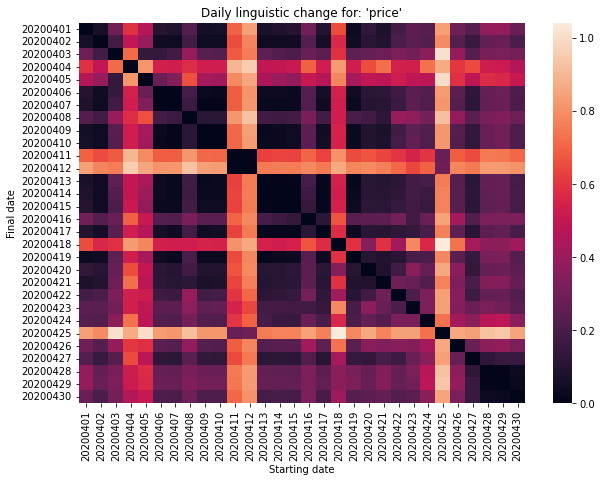

In [ ]:
targetWord = 'price'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting date")
ax.set_ylabel("Final date")
ax.set_ylabel("Final date")
ax.set_title("Daily linguistic change for: '{}'".format(targetWord))
plt.show()

business


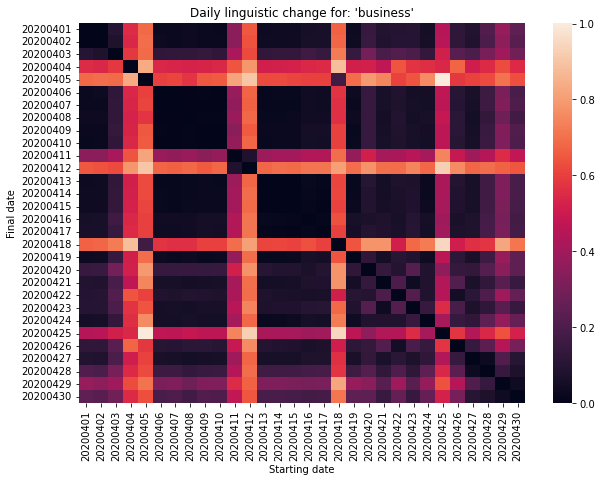

In [ ]:
targetWord = 'business'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting date")
ax.set_ylabel("Final date")
ax.set_ylabel("Final date")
ax.set_title("Daily linguistic change for: '{}'".format(targetWord))
plt.show()

This suggests that documents whose dates are close to each other demonstrates smaller linguistic changes for the same target word.

In [ ]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)

In [ ]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 22 words to compare


In [ ]:
wordDivergences

[('share', 8.54095746576786),
 ('year', 8.294242069125175),
 ('price', 8.114052280783653),
 ('end', 7.562844157218933),
 ('jones', 6.981946669518948),
 ('company', 6.90075096487999),
 ('newswires', 6.883389726281166),
 ('dow', 6.870648816227913),
 ('et', 6.190096043050289),
 ('april', 5.738448441028595),
 ('new', 5.534434512257576),
 ('business', 5.3996222615242),
 ('pandemic', 5.043962374329567),
 ('says', 4.951899580657482),
 ('production', 4.770423606038094),
 ('market', 4.609982788562775),
 ('demand', 4.398219078779221),
 ('coronavirus', 4.333737105131149),
 ('week', 4.174632713198662),
 ('said', 4.1189915984869),
 ('government', 3.8390850871801376),
 ('u.s', 3.58806973695755)]

share


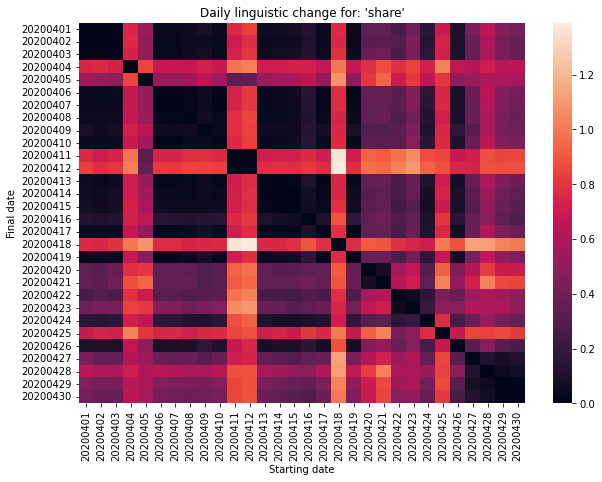

In [ ]:
targetWord = wordDivergences[0][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting date")
ax.set_ylabel("Final date")
ax.set_ylabel("Final date")
ax.set_title("Daily linguistic change for: '{}'".format(targetWord))
plt.show()

u.s


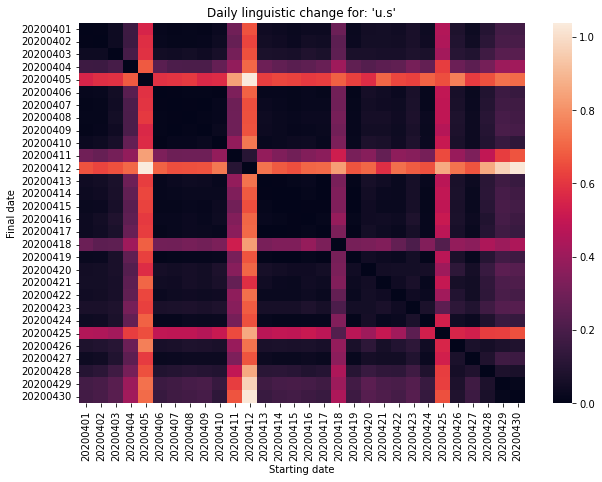

In [ ]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting date")
ax.set_ylabel("Final date")
ax.set_ylabel("Final date")
ax.set_title("Daily linguistic change for: '{}'".format(targetWord))
plt.show()

## Optional: Topic modeling with word embeddings

Recently computer scientists have developed methods to cluster word embeddings, which can be viewed as a topic model, an embedding-based version of conventional topic models that use the document-term matrix (e.g., LDA). One method is Discourse Atoms, first described by Princeton NLP researchers ([Arora et al. 2018](https://arxiv.org/abs/1601.03764)). This uses k-SVD, a generalization of the k-means clustering algorithm to identify topic-like vectors in the n-dimensional word embedding space. Below is code adapted from the first social science paper using Discourse Atoms, [Arseniev-Koehler et al. 2021](https://osf.io/preprints/socarxiv/nkyaq/). It takes as input _gensim_ word vectors.

You are not required to implement this, but for class projects or your own research, this can be more useful than conventional topic models. It runs faster, produces more detailed topics, and in general makes use of more information (i.e., word order within a document) than do conventional topic models. Note there are at least 4 other papers with methods for word embedding clusters:

- Xun, Li, Zhao, Gao, and Zhang 2017: [multivariate Gaussian distributions](https://www.ijcai.org/proceedings/2017/588)
- Dieng, Ruiz, and Blei 2019: ["Embedding Topic Model (ETM)"](https://arxiv.org/abs/1907.04907)
- Angelov 2020: ["Top2Vec"](https://arxiv.org/abs/2008.09470)
- Sia, Dalmia, and Mielke 2020: [(spherical) k-means, k-medoids, von Mises-Fisher Models, Gaussian Mixture Models](https://arxiv.org/abs/2004.14914)

Let's implement the Discourse Atoms method.

In [ ]:
# from gensim.test.utils import datapath 
# import re
# import string, re
# import cython

In [ ]:
# The ksvd package has a convenient Approximate k-SVD function.
!pip install ksvd

In [ ]:
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from random import seed, sample
from ksvd import ApproximateKSVD #pip or conda install ksvd #this is key!

In [ ]:
import pickle

In [ ]:
import math

In [ ]:
# Load a gensim word2vec model
w2v = senReleasesW2V

#### k-SVD

We then perform a K-SVD on the word embedding matrix to learn topics in such a way where each word-vector is represented as a spare linear combination of topics. To generate a good representation of the original word vector space, we want to minimize the difference between our word vectors and the vectors generated as a linear combination of topics. 




In [ ]:
#### TRAIN MODEL:

#n_comp: Number of topics (i.e., atoms, or dictionary elements)
#n_nonzeros: Number of nonzero coefficients to target (how many atoms each word can load onto)
            
def do_aksvd(w2vmodel, n_comp, n_nonzeros, save=False, savelocation='/content/aksvd_models/'): 
    #https://github.com/nel215/ksvd #takes about 2 min on Alina's laptop for 30 atoms 
    aksvd_t = ApproximateKSVD(n_components=n_comp, transform_n_nonzero_coefs=n_nonzeros) #also may adjuste n iter which is default at 10, and tolerance for error which is default at  tol=1e-6 #n_components is number of discourse atoms, since vocab size is smallish, keep this fewer. transform_n is the number of atoms (components) that a word can be a linear combo of
    dictionary_t = aksvd_t.fit(w2vmodel.wv.vectors).components_ # Dictionary is the matrix of discourse atoms. 
    alpha_t = aksvd_t.transform(w2vmodel.wv.vectors) #get the alphas, which are the "weights" of each word on a discourse atoms

    if save==True:
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_aksvd_nvdrsdf20','wb')
        pickle.dump(aksvd_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation) + '200d_' +str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_dictionary_nvdrsdf20','wb')
        pickle.dump(dictionary_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_alpha_nvdrsdf20','wb')
        pickle.dump(alpha_t,outfile)
        outfile.close()
    return(dictionary_t, alpha_t)

Two quick quality checks. These are useful to choose the number of atoms in the dictionary (i.e., number of topics): $R^2$ and Topic Diversity

Useful to look at product of the two since $R^2$ tends to increase with higher # topics, as Topic Diversity decreases. Intuition: more topics can better explain the original semantic space, but also then these topics are less distinct from one another. As a result, we typically want a balance between the two.

In [ ]:
def reconst_qual(w2vmodel, dictionary_mat, alpha_mat):
    #reconstruct the word vectors
    reconstructed = alpha_mat.dot(dictionary_mat) #reconstruct word vectors and add back in mean(?). but note that reconstructed norm is still around 0-1, not 1, is that an issue?
    #e1 = norm(w2vmodel.wv.vectors - reconstructed) #total reconstruction error, larger means MORE error. norm as specified here takes frobenius norm of error matrix.


    #total VARIANCE in the data: sum of squares 
    squares3= w2vmodel.wv.vectors-np.mean(w2vmodel.wv.vectors, axis=1).reshape(-1,1) #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sst3= np.sum([i.dot(i) for i in squares3] ) #same as below

    sst3= np.sum(np.square(squares3))


    #total sum of squared ERRORS/residuals
    e3= [reconstructed[i]-w2vmodel.wv.vectors[i] for i in range(0,len(w2vmodel.wv.vectors))]  #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sse3= np.sum([i.dot(i) for i in e3] ) #same as below
    sse3= np.sum(np.square(e3))

    #R^2: 1- (SSE / SST )
    r2= 1- (sse3 /  sst3) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error


    #compute root mean square error
    rmse=  math.sqrt(np.mean(np.square(e3)))



    return(sse3, rmse, r2) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error

#### Inferring topics from document

We now use a similar approach to what we saw a little earlier, where we inverted our generative model to see which documents belong to which class - we do the same now, but with discourse atoms instead of the whole model. This process tells us the topic most likely to have generated a specific context (document). 



In [ ]:
#topic diversity (% unique words among total closest 25 words to each atom)
def topic_diversity(w2vmodel, dictionary_mat, top_n=25):

    topwords=[] #list of list, each innter list includes top N words in that topic

    for i in range(0, len(dictionary_mat)): #set to number of total topics
        topwords.extend([i[0] for i in w2vmodel.wv.similar_by_vector(dictionary_mat[i],topn=top_n)]) #set for top N words 
        #print(w2vmodel.wv.similar_by_vector(dictionary[i],topn=N))

    uniquewords= set(topwords)
    diversity = len(uniquewords)/len(topwords)
    return(diversity)

In [ ]:
dictionary, alpha = do_aksvd(w2v, 150, 5, save=True)

In [ ]:
topic_diversity(w2v, dictionary, top_n=25)

0.8885333333333333

In [ ]:
reconst_qual(w2v, dictionary, alpha)


(2398540.8915694184, 0.894244689800385, 0.4193311633201203)

In [ ]:
#loading back in the model pieces if not already in

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_dictionary_nvdrsdf20','rb')
# dictionary=pickle.load(infile)
# infile.close()

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_aksvd_nvdrsdf20','rb')
# aksvd=pickle.load(infile)
# infile.close()

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_alpha_nvdrsdf20','rb')
# alpha=pickle.load(infile)
# infile.close()

In [ ]:
for i in range(0, len(dictionary)):
    print("Discourse_Atom " + str(i))
    print([i[0] for i in w2v.wv.similar_by_vector(dictionary[i],topn=25)]) #what are the most similar words to the Nth
    #print([i[0] for i in w2vmodel.wv.similar_by_vector(-dictionary[i],topn=25)]) #what are the most similar words to the Nth dicourse atom?
    print('\n')


Discourse_Atom 0
['Egypts', 'Morsi', 'Morsi,', 'Morsis', 'Mubarak', 'Brotherhood', 'Egypt', 'Egyptian', 'ouster', 'coup', 'Islamist', 'Mohamed', 'Islamists', 'Egypt,', 'Cairo', 'generals', 'democratic', 'democracy.', 'ousted', 'legitimacy', 'Mahmoud', 'democracy', 'democracy,', 'Spring', 'Abdullah']


Discourse_Atom 1
['Derby', 'Triple', 'Belmont', 'Premier', 'Champions', 'Manchester', 'Crown', 'horse', 'League', 'winner,', 'horses', 'Real', 'Yankees', 'Yankees,', 'league', 'team', 'trainer', 'season', 'club', 'Chelsea', 'teams', 'Cup', 'Soccer', 'clubs', 'winning']


Discourse_Atom 2
['Brazil', 'Brazil,', 'Cup,', 'Cup', 'Germany', 'States,', 'countries', 'Cup.', 'Europe', 'Europe,', 'United', 'Portugal', 'countries,', 'nations,', 'Sweden', 'Argentina', 'Netherlands', 'World', 'Australia', 'Canada', 'Japan,', 'Africa', 'Germany,', 'States', 'Italy']


Discourse_Atom 3
['happened', 'moment', 'tragedy', 'story', 'happened.', 'tragic', 'nature', 'happened,', 'moments', 'truth', 'what', 'n

In [ ]:
# for a specific atom, e.g., 112th atom look at 25 most similar words:
w2v.wv.similar_by_vector(dictionary[112],topn=25)

[('court', 0.7905327081680298),
 ('judge', 0.7822369337081909),
 ('Court', 0.7414460182189941),
 ('courts', 0.7331409454345703),
 ('judges', 0.7240278124809265),
 ('Supreme', 0.7147840261459351),
 ('ruling', 0.711248517036438),
 ('case', 0.7036005854606628),
 ('appeals', 0.6984674334526062),
 ('Judge', 0.6953557729721069),
 ('lawyers', 0.681331992149353),
 ('ruling,', 0.6630173921585083),
 ('judge,', 0.6567955613136292),
 ('court,', 0.6532109975814819),
 ('plaintiffs', 0.6437978148460388),
 ('justices', 0.6303653717041016),
 ('legal', 0.6270549297332764),
 ('case,', 0.6229175329208374),
 ('ruling.', 0.6145539879798889),
 ('Court,', 0.6115553379058838),
 ('Circuit', 0.6098675727844238),
 ('court.', 0.6063867211341858),
 ('case.', 0.6011309623718262),
 ('trial', 0.5913736820220947),
 ('Justice', 0.5887668132781982)]

In [ ]:
print(w2v.wv.vocab.get('the').index, '\n', alpha[w2vmodel.wv.vocab.get('the').index])



1 
 [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.00273484 -0.00186215  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.00216819  0.          0.          0.          0.
  0.         -0.002954    0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.     

In [ ]:
#useful relevant code:
#w2vmodel.wv.index2word[3452]
#w2vmodel.wv.most_similar('the', topn=15)
#np.where(alpha[w2vmodel.wv.vocab.get('the').index] != 0) #get index where the loading of a word onto discourse atoms is not 0